# Introduction

This notebook is designed to create a strong benchmark model for predicting flight performance using XGBoost, a powerful yet relatively simple machine learning algorithm. We will use basic meteorological and site-related features and a few hand-crafted features to train our model. The goal is to achieve a high ROC-AUC score, indicating strong predictive performance. This benchmark model will serve as a foundation before we progress to more complex models (such as neural networks) with additional features. By establishing a solid baseline, we can better evaluate the improvements gained from more sophisticated approaches in future iterations.



### Setup

In [1]:
import os
import logging

import numpy as np
import pandas as pd
from dotenv import load_dotenv
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import xgboost as xgb
from sklearn.model_selection import train_test_split, ParameterSampler
from sklearn.metrics import roc_auc_score
from scipy.stats import loguniform, uniform


import utils

/mnt/c/Users/janhe/OneDrive/Plocha/repos/glideator/analytics/env-jl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

In [4]:
load_dotenv()

connection_string = "postgresql://{user}:{password}@{host}:{port}/{db}".format(
    user=os.getenv('DB_USER'),
    password=os.getenv('DB_PASSWORD'),
    host=os.getenv('DB_HOST'),
    port=os.getenv('DB_PORT'),
    db=os.getenv('DB_NAME')
)
engine = create_engine(connection_string)

### Load data from Glideator FS

In [5]:
query = """
SELECT
    features.*,
    stats.flight_registered,
    stats.max_points,
    stats.flight_cnt
FROM glideator_mart.mart_daily_flight_stats stats
JOIN glideator_fs.fs_benchmark_features features
    ON stats.launch = features.launch
    AND stats.date = features.date
"""
df = pd.read_sql(query, engine)
df.head()

launch        date  u_wind_ms  v_wind_ms  wind_direction_dgr  wind_speed_ms  \
0   Brná  2015-01-15      -1.78       5.34          161.565052       5.628854   
1   Brná  2015-01-17       1.58      -1.44          312.345805       2.137756   
2   Brná  2015-01-18      -1.13       2.31          153.933160       2.571575   
3   Brná  2015-01-19      -1.98       2.86          145.304845       3.478505   
4   Brná  2015-01-20      -0.98       2.34          157.275897       2.536927   

   gust_speed_ms  dewpoint_c_surface  temperature_c_surface  \
0           10.4           -1.120001               2.649988   
1            4.4            0.920007               2.610010   
2            3.1           -2.449988               2.800012   
3            4.5           -2.250006               1.219995   
4            3.3           -3.549994              -0.160010   

   pressure_surface_hpa  ...  usable_range1_from  usable_range1_to  \
0            960.274219  ...                 180               210   
1            962.038359  ...                 180               210   
2            965.441641  ...                 180               210   
3            961.597344  ...                 180               210   
4            959.430469  ...                 180               210   

   usable_range2_from  usable_range2_to  \
0                 NaN               NaN   
1                 NaN               NaN   
2                 NaN               NaN   
3                 NaN               NaN   
4                 NaN               NaN   

                                       temperature_c  \
0  [2.6499877929687727, 1.8500000000000227, 1.749...   
1  [2.6100097656250227, 1.8500000000000227, 1.749...   
2  [2.8000122070312727, 1.5500122070312727, 1.350...   
3  [1.2199951171875227, -0.04999389648435226, -0....   
4  [-0.16000976562497726, -1.3500122070312273, -1...   

                                         height_amsl  \
0  [435.12064, 513.1206, 519.99396, 533.1206, 734...   
1  [435.12064, 513.1206, 533.1206, 534.8343, 749....   
2  [435.12064, 513.1206, 533.1206, 563.1034, 776....   
3  [435.12064, 513.1206, 530.4034, 533.1206, 743....   
4  [435.12064, 512.02484, 513.1206, 533.1206, 723...   

                                                dalr flight_registered  \
0  [2.6499877929687727, 1.8855880920410384, 1.818...                 1   
1  [2.6100097656250227, 1.8456100646972884, 1.649...                 0   
2  [2.8000122070312727, 2.035612506103538, 1.8396...                 1   
3  [1.2199951171875227, 0.4555954162597884, 0.286...                 0   
4  [-0.16000976562497726, -0.9136709777831804, -0...                 0   

  max_points flight_cnt  
0       1.53          1  
1       0.00          0  
2       3.73          5  
3       0.00          0  
4       0.00          0  

[5 rows x 23 columns]

In [6]:
df.shape

(65936, 23)

### Create derived features

We create several derived features to enhance our model's predictive power:

1. **area_under_dalr**: Calculates the area between the Dry Adiabatic Lapse Rate (DALR) curve
   and the Environmental Lapse Rate (ELR) curve. This area represents the potential
   energy available for thermal development, with larger areas indicating greater
   instability and stronger thermal activity.

2. **thermal_top**: Estimates the maximum height thermals can reach based on the 
   temperature profile and DALR, crucial for understanding thermaling conditions.

3. **temp_dewpoint_spread_surface**: The difference between surface temperature and 
   dewpoint, which can indicate atmospheric instability and likelihood of thermal formation.

4. **week_day**: Extracted from the date, this feature can capture weekly patterns in 
   flight activity (e.g., more flights on weekends).

5. **year**: Extracted from the date to potentially capture long-term trends.



In [7]:
df['area_under_dalr'] = df.apply(lambda row: utils.area_under_darl(row['dalr'], row['temperature_c'], row['height_amsl']), axis=1)
df['thermal_top'] = df.apply(lambda row: utils.thermal_top(row['dalr'], row['temperature_c'], row['height_amsl']), axis=1)
df['temp_dewpoint_spread_surface'] = df['temperature_c_surface'] - df['dewpoint_c_surface']
df['weekend'] = df['date'].apply(lambda date: date.weekday() >= 5)
df['year'] = df['date'].apply(lambda date: date.year)
df['day_of_year'] = df['date'].apply(lambda date: date.timetuple().tm_yday)
df['day_of_year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365.25)
df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365.25)

In [8]:
df['XC30'] = df['max_points'] > 30

In [9]:
TARGET = 'XC30'
FEATURES = [
    #weather features
    'u_wind_ms',
    'v_wind_ms',
    'gust_speed_ms',
    'dewpoint_c_surface',
    'temperature_c_surface',
    'temp_dewpoint_spread_surface', 
    'area_under_dalr',
    'thermal_top',
    'pressure_surface_hpa',
    'precipitable_water_kgm2',
    #launch features
    'altitude',
    'superelevation',
    'usable_range1_from',
    'usable_range1_to',
    'usable_range2_from',
    'usable_range2_to',
    #date features
    'weekend',
    'year',
    'day_of_year_sin',
    'day_of_year_cos'
]

### Setup hyperparameter search

In [10]:
def get_uniform(min, max):
    """Transform min (lower bound) and max (upper bound) 
    to scipy.stats.uniform parameters"""
    return uniform(loc=min, scale=max-min)


def perform_hyperparameter_search(X, y, search_space, fixed_params, n_iter=100):
    """
    Perform a randomized hyperparameter search for XGBoost model optimization.

    This function conducts a randomized search over a specified hyperparameter space
    for an XGBoost binary classification model. It uses cross-validation to evaluate
    each hyperparameter combination and returns the results sorted by ROC-AUC score.

    Parameters:
    -----------
    X : pandas.DataFrame
        The feature matrix.
    y : pandas.Series
        The target variable (binary).
    search_space : dict
        A dictionary specifying the hyperparameter search space.
    fixed_params : dict
        A dictionary of fixed parameters for the XGBoost model.
    n_iter : int, optional (default=100)
        The number of parameter settings that are sampled.

    Returns:
    --------
    pandas.DataFrame
        A DataFrame containing the results of the hyperparameter search,
        including the hyperparameters, ROC-AUC score, and best iteration
        for each combination tried.

    Notes:
    ------
    - The function uses stratified train-test splits for each iteration.
    - Early stopping is employed during training to prevent overfitting.
    - The ROC-AUC score is used as the evaluation metric.
    """
    # Generate a randomized sample of hyperparameter combinations
    param_combinations = list(ParameterSampler(search_space, n_iter=n_iter, random_state=42))

    # Prepare to store the results
    results = []
    best_roc_auc = 0
    best_params = None

    # Iterate over each randomized hyperparameter combination
    for idx, params in enumerate(param_combinations):
        # Split the data into training and validation sets for each parameter combination
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.2, random_state=42*idx, stratify=y
        )
        
        # Set up XGBoost parameters
        xgb_params = {
            **fixed_params,
            **params  # Unpack the hyperparameters
        }
        
        # Convert data to DMatrix format
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dval = xgb.DMatrix(X_val, label=y_val)
        
        # Train the model with early stopping
        evallist = [(dtrain, 'train'), (dval, 'eval')]
        model = xgb.train(
            xgb_params,
            dtrain,
            evals=evallist,
            early_stopping_rounds=10,
            verbose_eval=False,
            num_boost_round=1000,
        )
        
        # Predict probabilities on the validation set
        y_pred_proba = model.predict(dval, iteration_range=(0, model.best_iteration))
        
        # Compute ROC-AUC
        roc_auc = roc_auc_score(y_val, y_pred_proba)
        
        # Update best score and parameters if necessary
        if roc_auc > best_roc_auc:
            best_roc_auc = roc_auc
            best_params = params

        # Append the results
        result = params.copy()
        result['roc_auc'] = roc_auc
        result['best_iteration'] = model.best_iteration
        results.append(result)

        # Log every 10th iteration
        if (idx + 1) % 10 == 0:
            logging.info(f"Iteration {idx + 1}/{len(param_combinations)}: Best ROC-AUC so far: {best_roc_auc:.4f}")
            logging.info(f"Best parameters: {best_params}")

    # Convert results to a DataFrame for analysis
    results_df = pd.DataFrame(results)
    
    return results_df

### Execute the hyperparameter search and analyze the results


In [11]:
N_ITER = 10

X = df[FEATURES]
y = df[TARGET]

SEARCH_SPACE = {
    'learning_rate': loguniform(0.01, 0.3),
    'max_depth': range(3, 12),
    'gamma': loguniform(0.01, 0.3),
    'alpha': loguniform(0.001, 10.),
    'lambda': loguniform(0.001, 1.),
    'subsample': get_uniform(0.5, 1),
    'colsample_bytree': get_uniform(0.5, 1),
}
FIXED_PARAMS = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'seed': 42,
    'n_jobs': -1
}

results_df = perform_hyperparameter_search(X, y, SEARCH_SPACE, FIXED_PARAMS, N_ITER)

print("Hyperparameter Search Results:")
results_df.sort_values(by='roc_auc', ascending=False).head()

2024-09-24 08:24:28,285 - Iteration 10/10: Best ROC-AUC so far: 0.9720
2024-09-24 08:24:28,289 - Best parameters: {'alpha': np.float64(0.18655260217376832), 'colsample_bytree': np.float64(0.5156566462277793), 'gamma': np.float64(0.17545136166066808), 'lambda': np.float64(0.02234922151767551), 'learning_rate': np.float64(0.03834288724218001), 'max_depth': 6, 'subsample': np.float64(0.7989499894055425)}


Hyperparameter Search Results:


alpha  colsample_bytree     gamma    lambda  learning_rate  max_depth  \
7  0.186553          0.515657  0.175451  0.022349       0.038343          6   
8  4.869641          0.544246  0.019476  0.001367       0.030238          4   
5  7.286654          0.904199  0.028181  0.001963       0.102493          9   
9  0.222333          0.982628  0.078825  0.006730       0.027393          3   
4  8.568870          0.733381  0.186310  0.109881       0.046285          4   

   subsample   roc_auc  best_iteration  
7   0.798950  0.972020             421  
8   0.769846  0.971479             997  
5   0.804998  0.970985             148  
9   0.507818  0.970656             926  
4   0.974443  0.969360             624

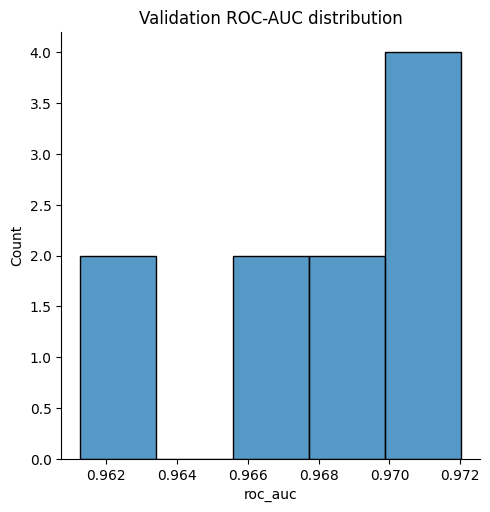

In [12]:
sns.displot(results_df['roc_auc'])
plt.title('Validation ROC-AUC distribution')
plt.show()

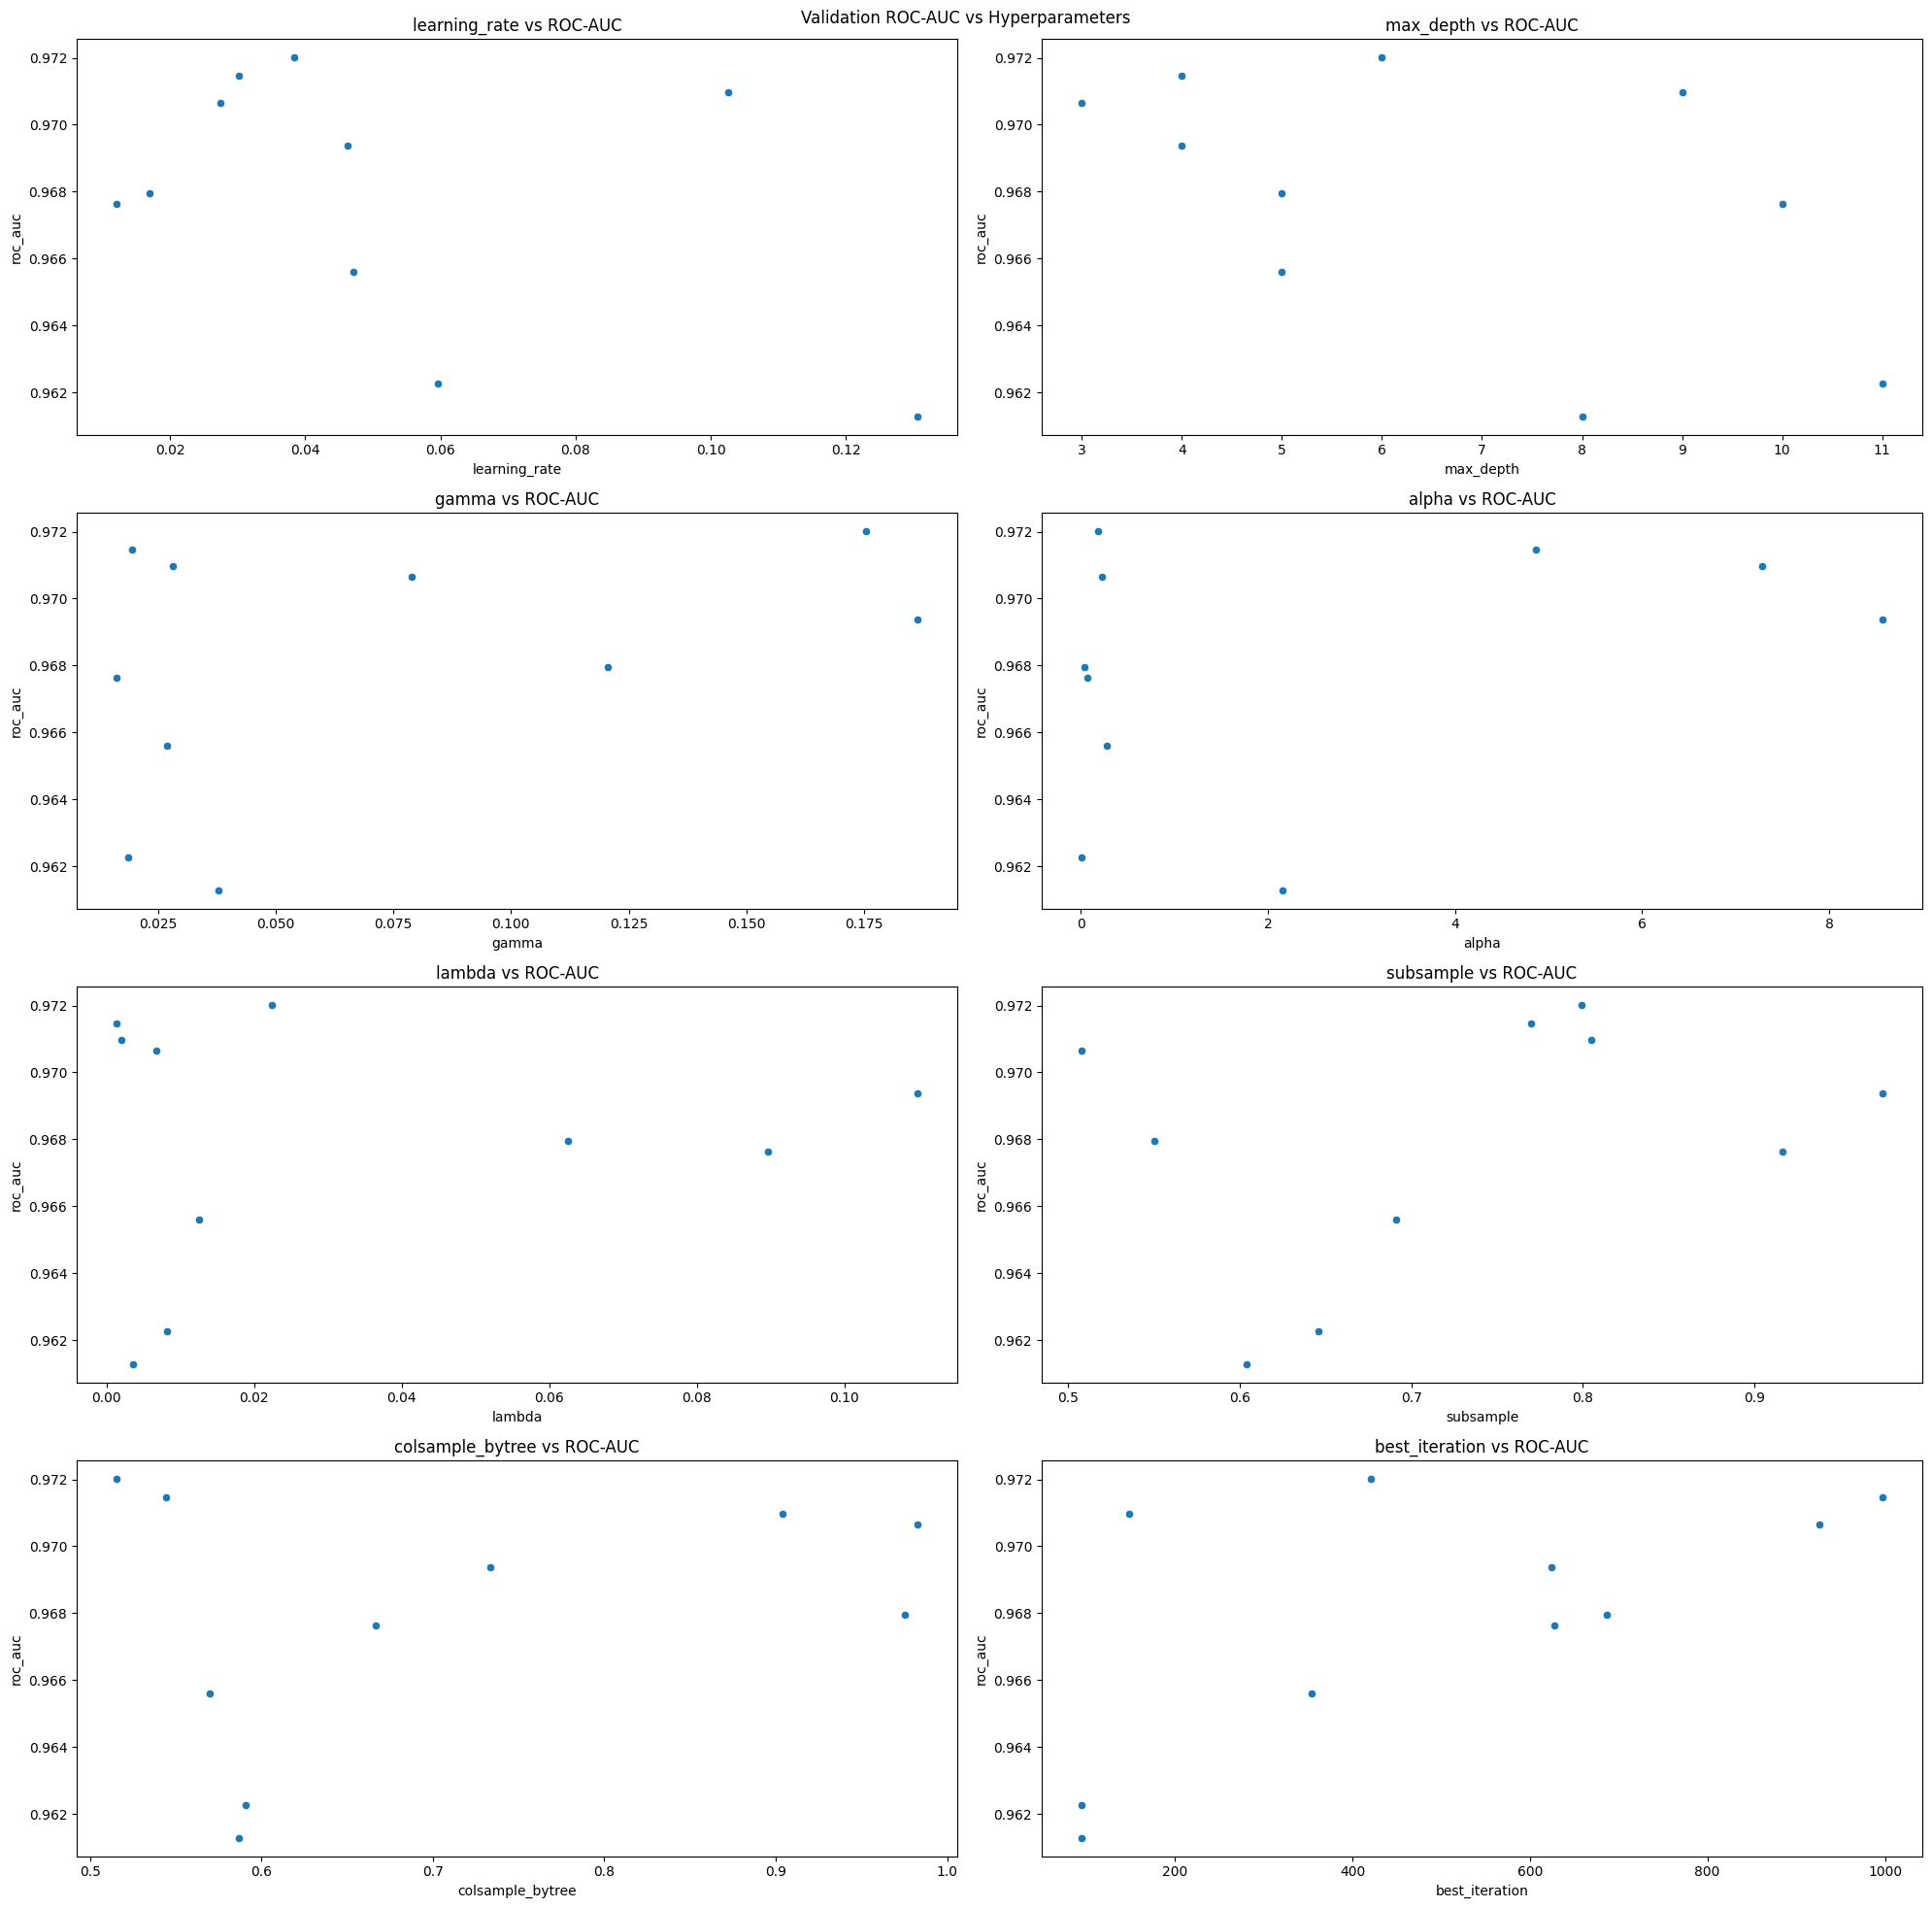

In [13]:
plot_keys = list(SEARCH_SPACE.keys()) + ['best_iteration']

n_rows = (len(plot_keys) + 1) // 2

fig, axes = plt.subplots(n_rows, 2, figsize=(20, 5*n_rows))
axes = axes.flatten()

for i, key in enumerate(plot_keys):
    sns.scatterplot(x=key, y='roc_auc', data=results_df, ax=axes[i])
    axes[i].set_title(f'{key} vs ROC-AUC')

for i in range(len(plot_keys), len(axes)):
    fig.delaxes(axes[i])

plt.suptitle('Validation ROC-AUC vs Hyperparameters')
plt.tight_layout()
plt.show()



### Retrain the model with the best hyperparameters and evaluate results


2024-09-24 08:24:37,495 - Retraining with best hyperparameters: {'learning_rate': 0.03834288724218001, 'max_depth': 6, 'gamma': 0.17545136166066808, 'alpha': 0.18655260217376832, 'lambda': 0.02234922151767551, 'subsample': 0.7989499894055425, 'colsample_bytree': 0.5156566462277793}


[0]	train-logloss:0.19593	train-auc:0.89897	eval-logloss:0.19591	eval-auc:0.88769
[1]	train-logloss:0.19136	train-auc:0.92924	eval-logloss:0.19139	eval-auc:0.92184
[2]	train-logloss:0.18650	train-auc:0.94578	eval-logloss:0.18673	eval-auc:0.93468
[3]	train-logloss:0.18186	train-auc:0.94828	eval-logloss:0.18221	eval-auc:0.93687
[4]	train-logloss:0.17768	train-auc:0.95267	eval-logloss:0.17819	eval-auc:0.93890
[5]	train-logloss:0.17333	train-auc:0.95375	eval-logloss:0.17399	eval-auc:0.94019
[6]	train-logloss:0.16955	train-auc:0.95638	eval-logloss:0.17031	eval-auc:0.94193
[7]	train-logloss:0.16604	train-auc:0.95617	eval-logloss:0.16685	eval-auc:0.94254
[8]	train-logloss:0.16238	train-auc:0.95928	eval-logloss:0.16330	eval-auc:0.94674
[9]	train-logloss:0.15883	train-auc:0.96087	eval-logloss:0.15986	eval-auc:0.94777
[10]	train-logloss:0.15539	train-auc:0.96087	eval-logloss:0.15659	eval-auc:0.94736
[11]	train-logloss:0.15219	train-auc:0.96080	eval-logloss:0.15352	eval-auc:0.94708
[12]	train-log

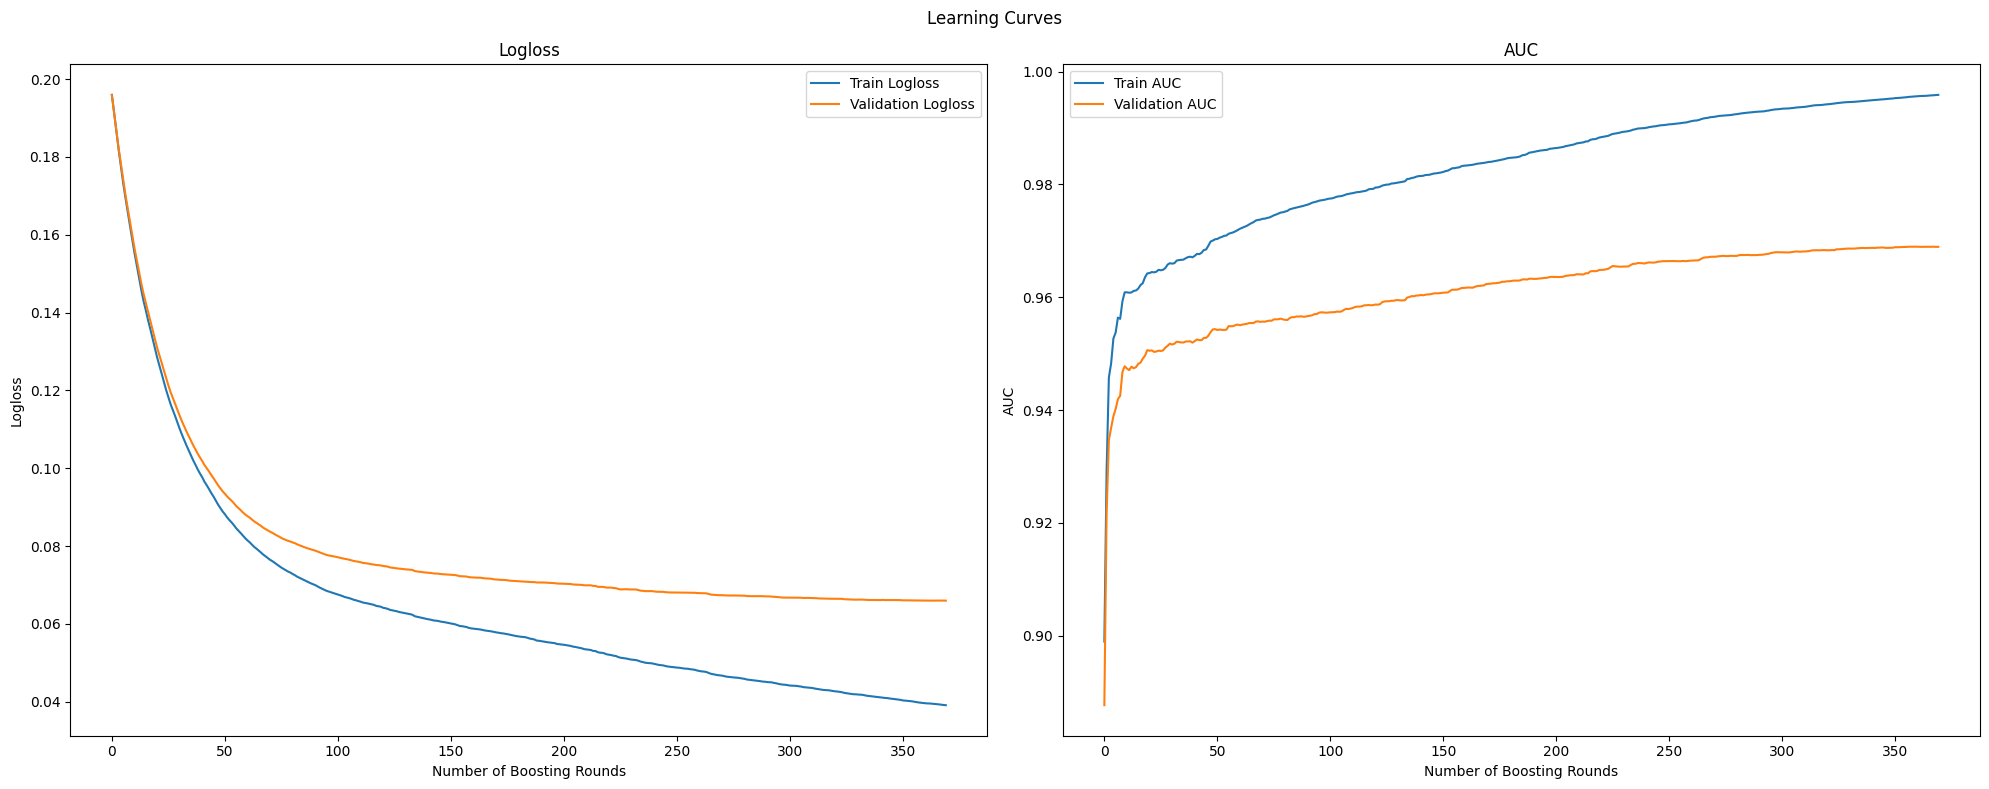

In [14]:
best_idx = results_df['roc_auc'].idxmax()
best_params = results_df[SEARCH_SPACE.keys()].to_dict(orient='records')[best_idx]

logging.info(f"Retraining with best hyperparameters: {best_params}")

X = df
y = df[TARGET]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'seed': 42,
    'eval_metric': ['logloss', 'auc'],
    **best_params
}

dtrain = xgb.DMatrix(X_train[FEATURES], label=y_train)
dval = xgb.DMatrix(X_val[FEATURES], label=y_val)

evals_result = {}

model = xgb.train(
    xgb_params,
    dtrain,
    evals=[(dtrain, 'train'), (dval, 'eval')],
    early_stopping_rounds=10,
    verbose_eval=True,
    num_boost_round=1000,
    evals_result=evals_result,
)

y_pred_proba = model.predict(dval, iteration_range=(0, model.best_iteration))

# Plot learning curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Logloss plot
ax1.plot(evals_result['train']['logloss'], label='Train Logloss')
ax1.plot(evals_result['eval']['logloss'], label='Validation Logloss')
ax1.set_title('Logloss')
ax1.set_xlabel('Number of Boosting Rounds')
ax1.set_ylabel('Logloss')
ax1.legend()

# AUC plot
ax2.plot(evals_result['train']['auc'], label='Train AUC')
ax2.plot(evals_result['eval']['auc'], label='Validation AUC')
ax2.set_title('AUC')
ax2.set_xlabel('Number of Boosting Rounds')
ax2.set_ylabel('AUC')
ax2.legend()

plt.suptitle('Learning Curves')
plt.tight_layout()
plt.show()

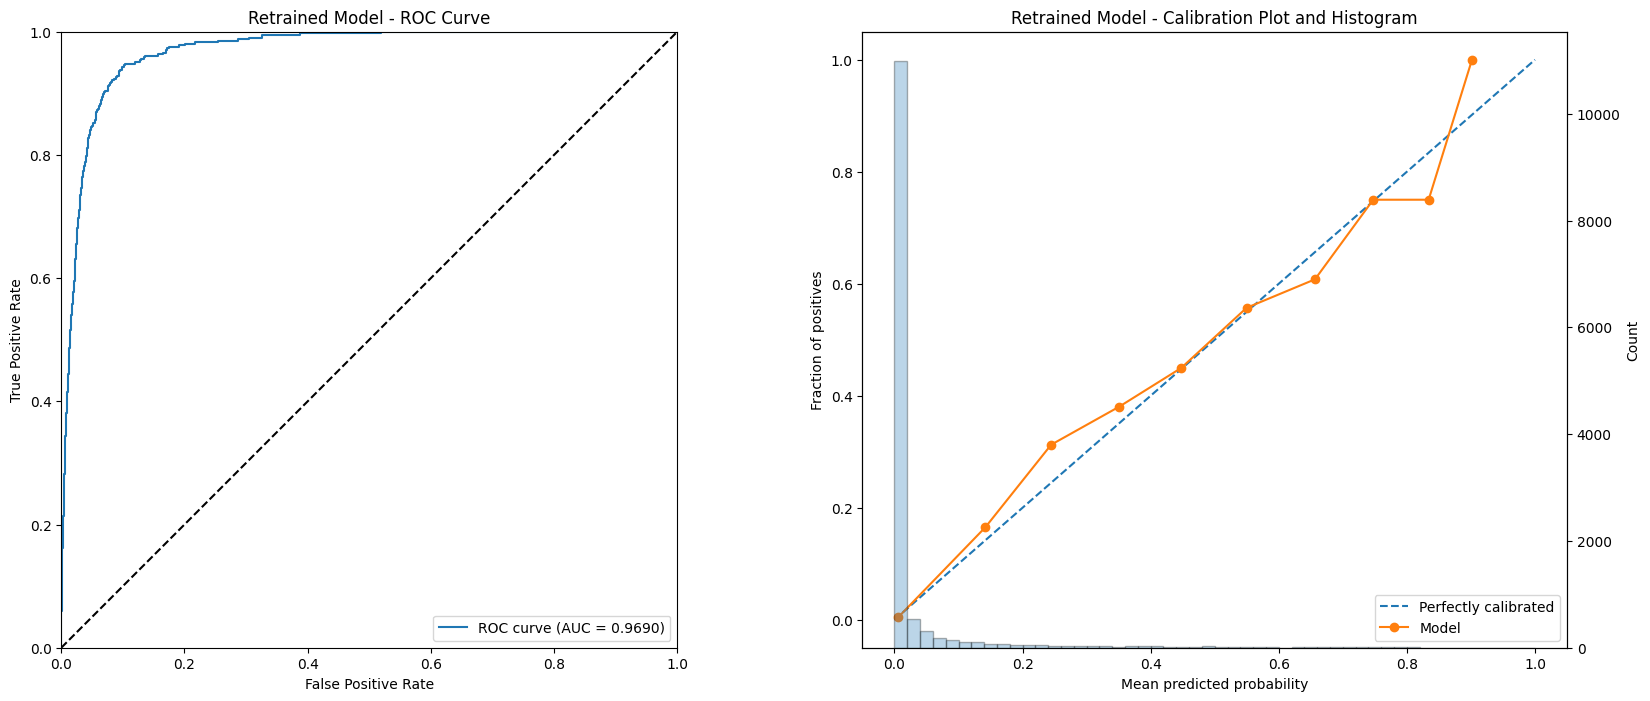

<Figure size 1000x800 with 0 Axes>

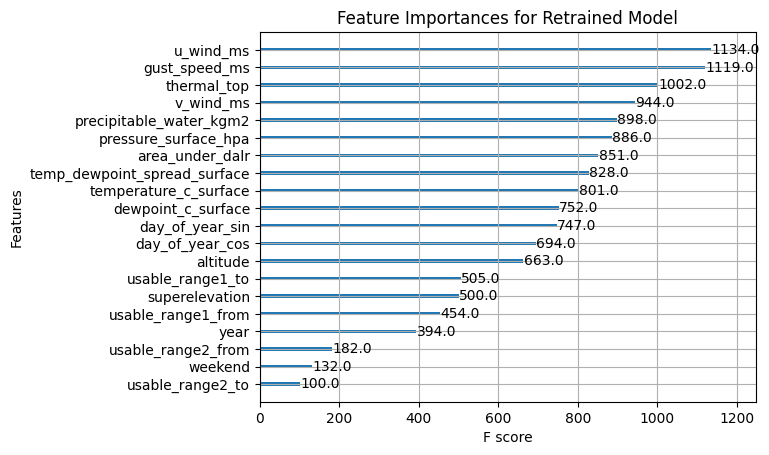

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
utils.plot_roc_curve(y_val, y_pred_proba, ax=ax1)
ax1.set_title(f'Retrained Model - ROC Curve')

utils.plot_calibration_and_histogram(y_val, y_pred_proba, ax=ax2)
ax2.set_title(f'Retrained Model - Calibration Plot and Histogram')
plt.show()

plt.figure(figsize=(10, 8))
xgb.plot_importance(model, max_num_features=50)
plt.title('Feature Importances for Retrained Model')
plt.show()

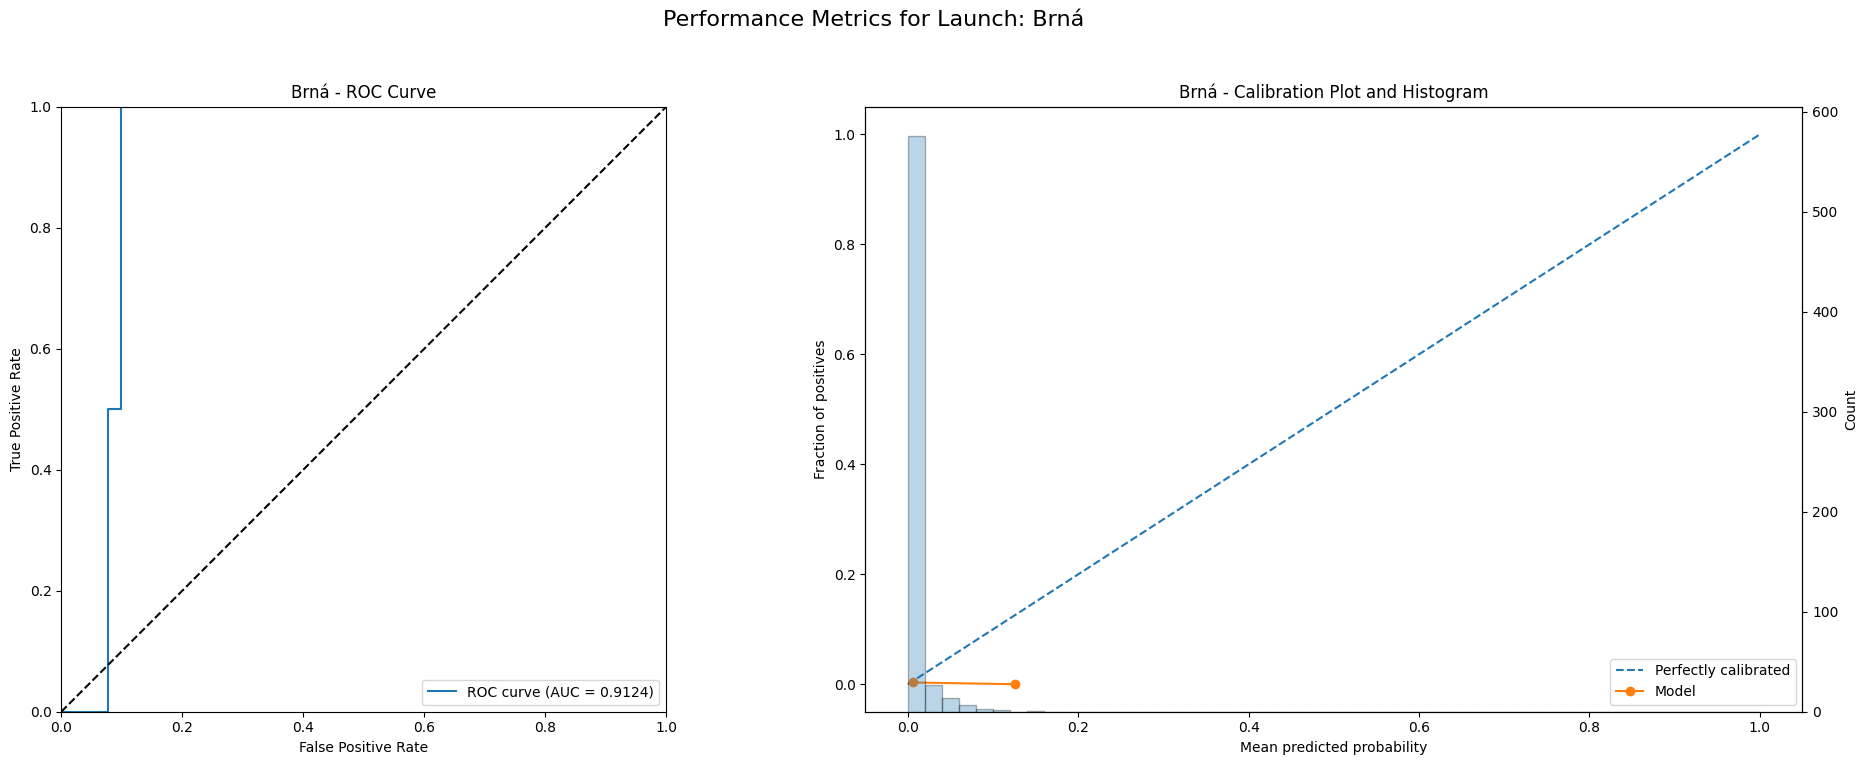

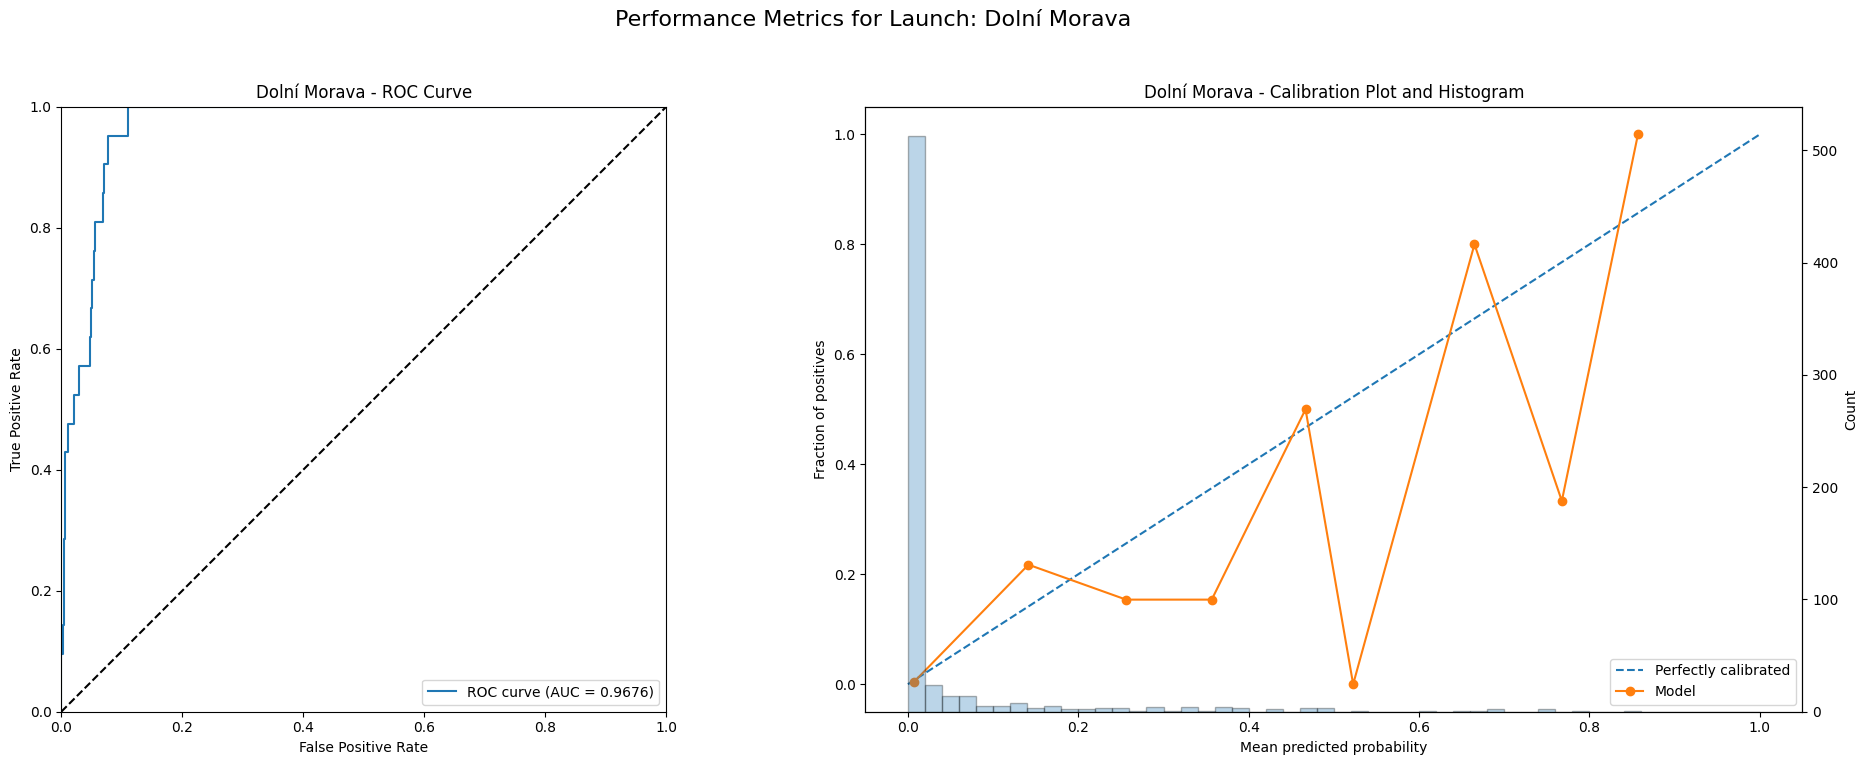

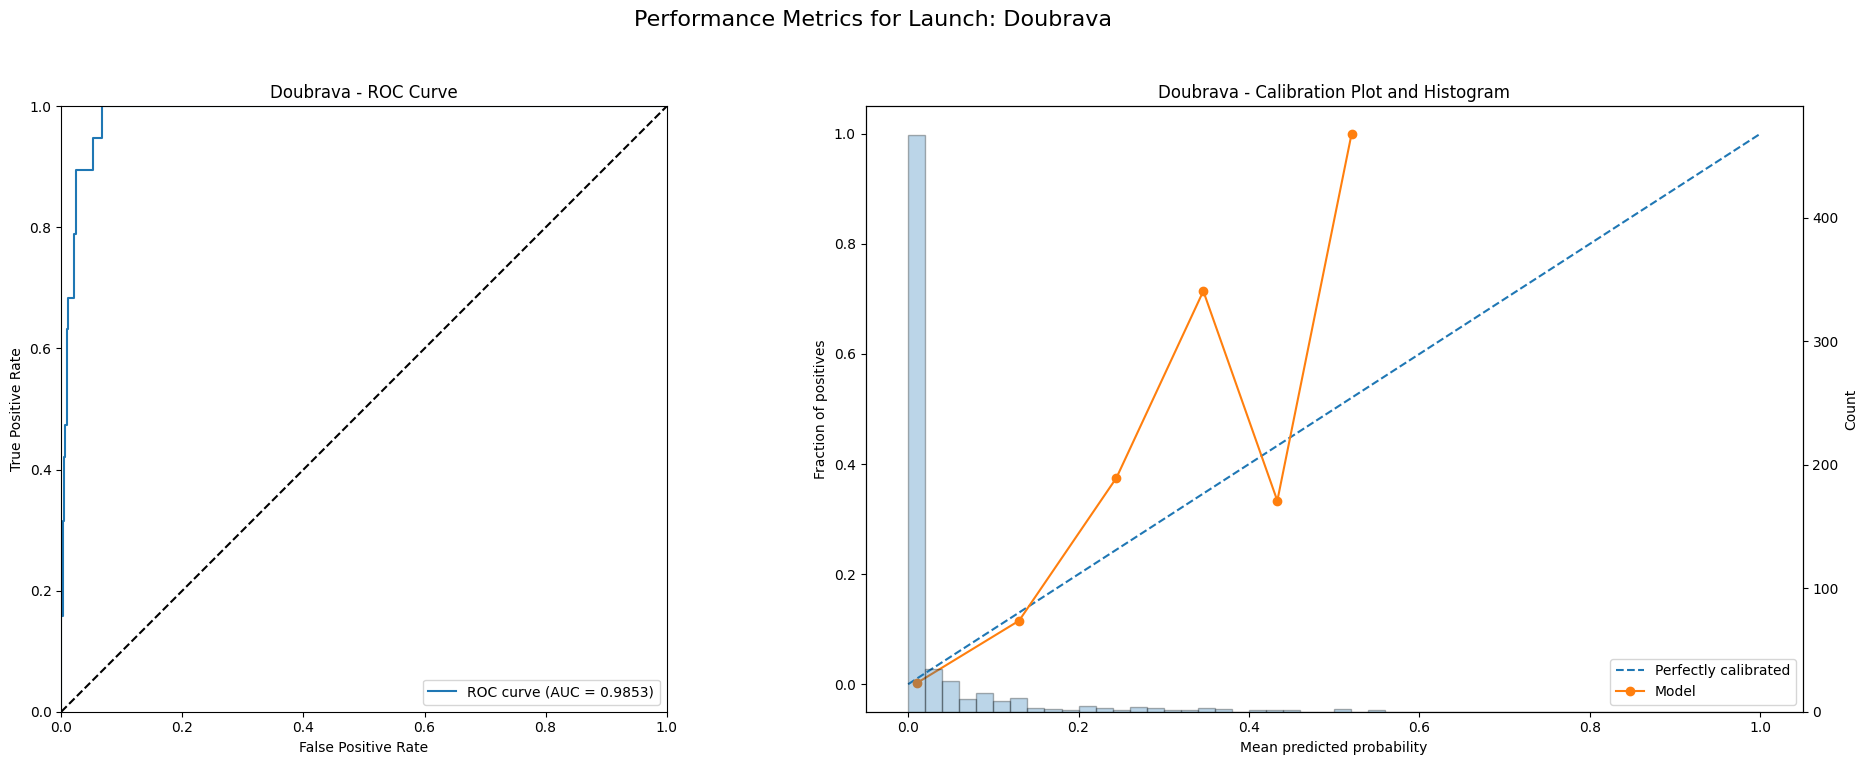

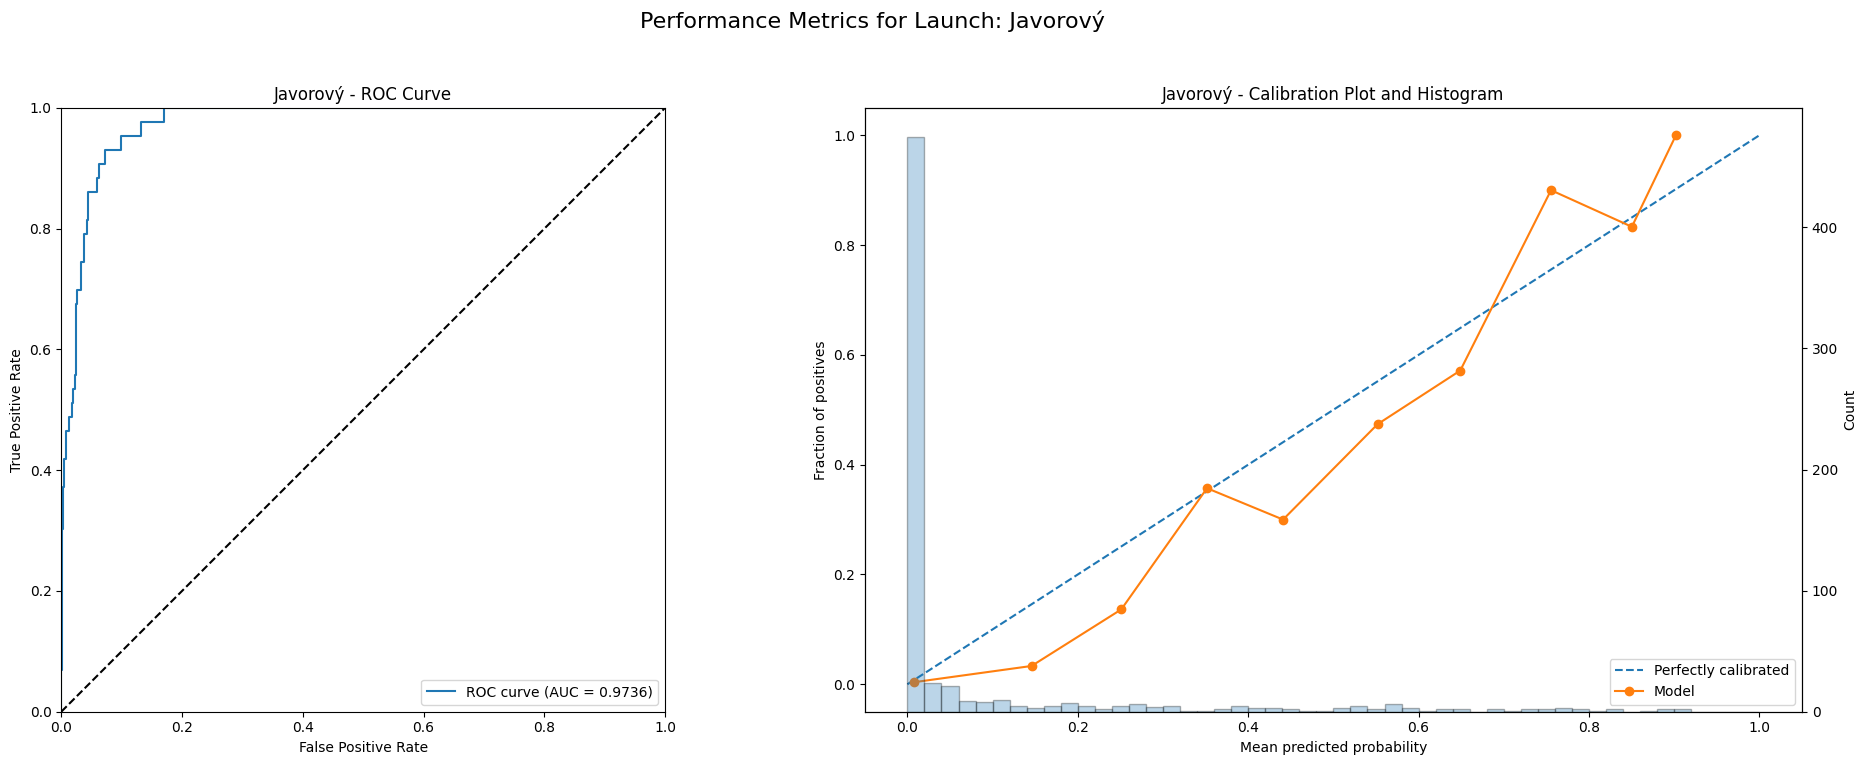

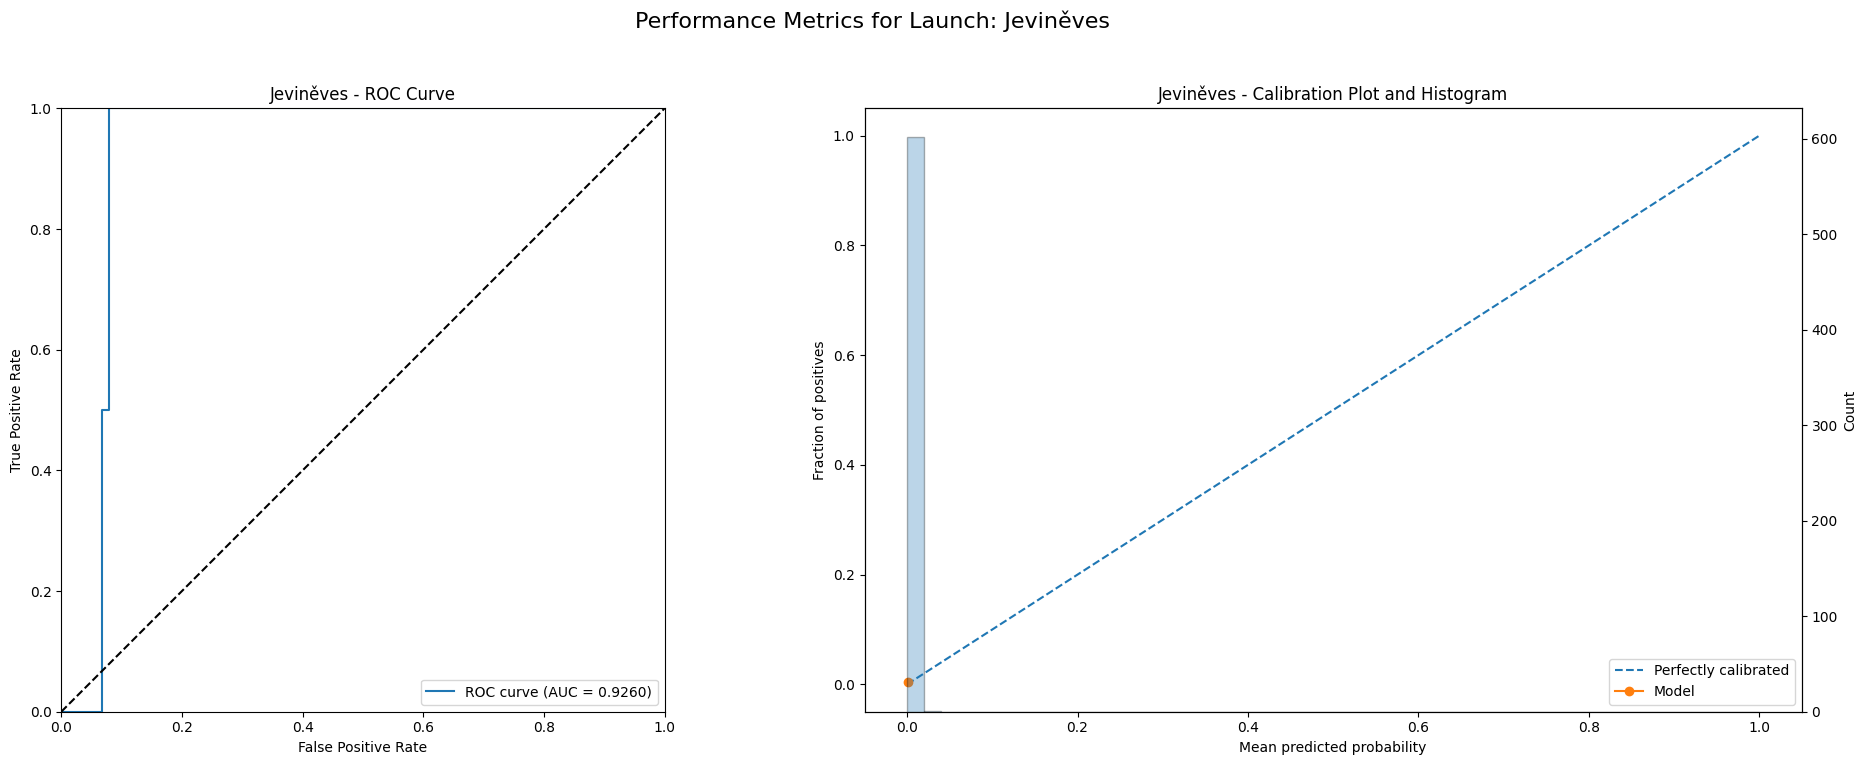

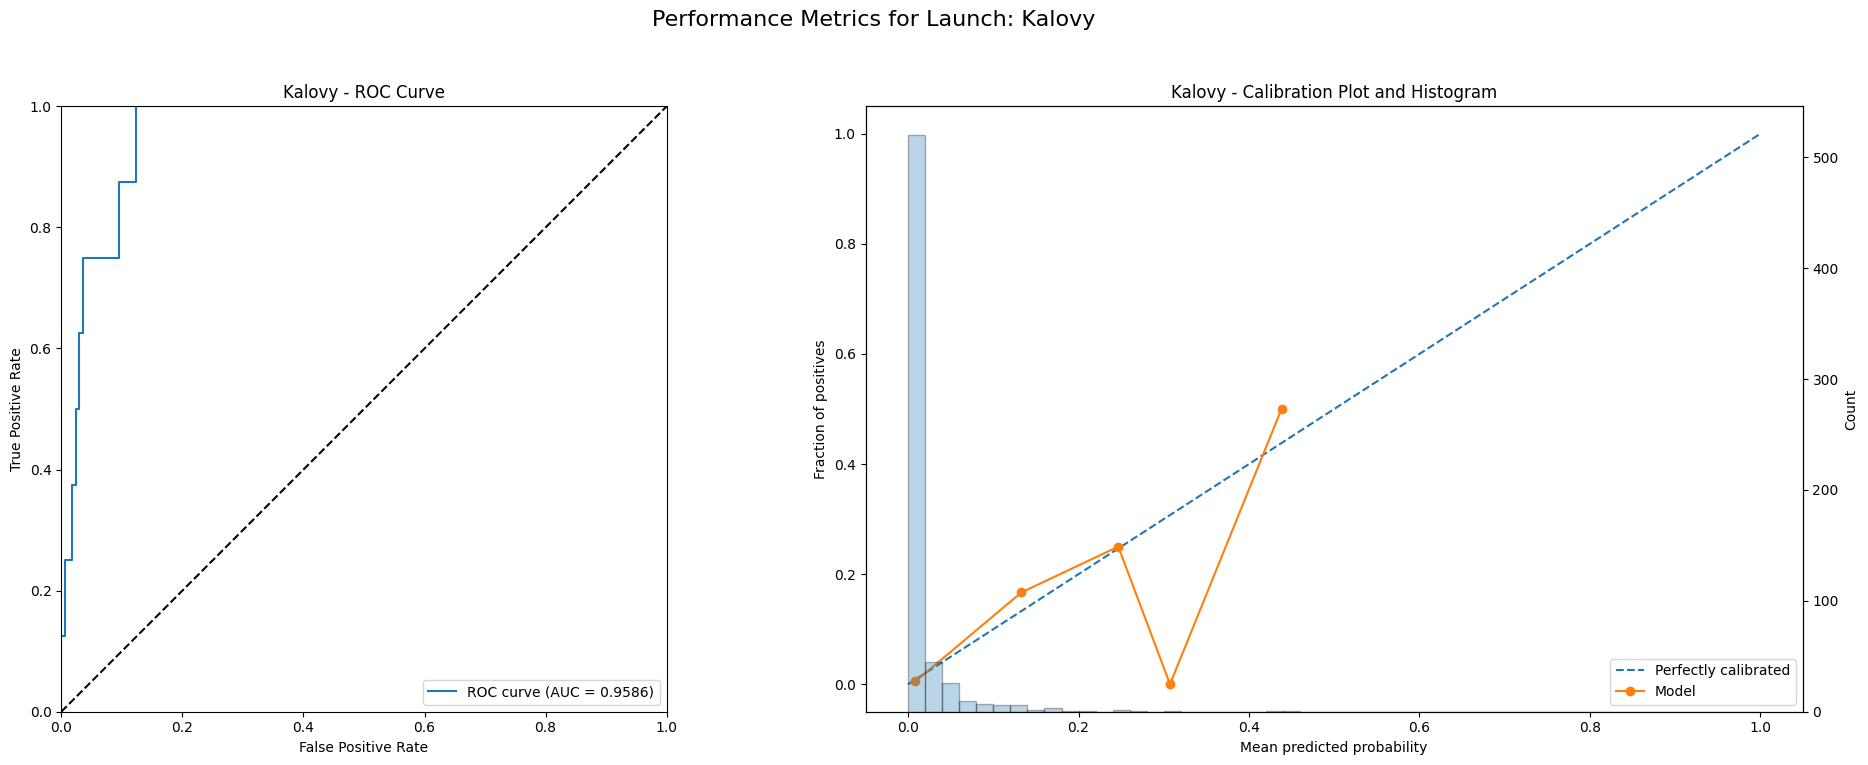

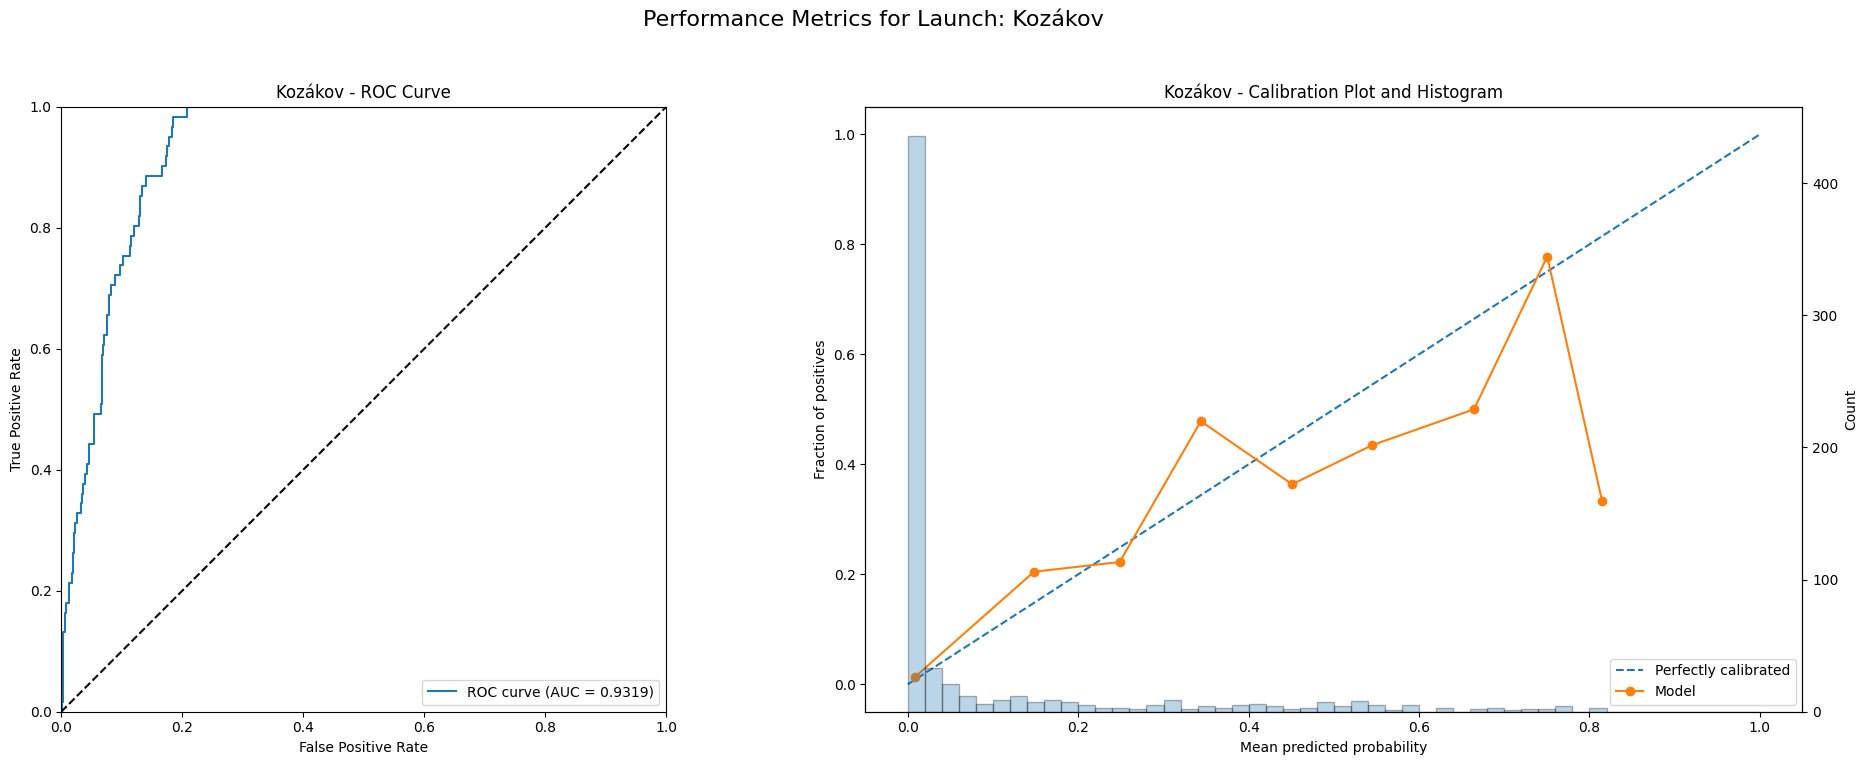

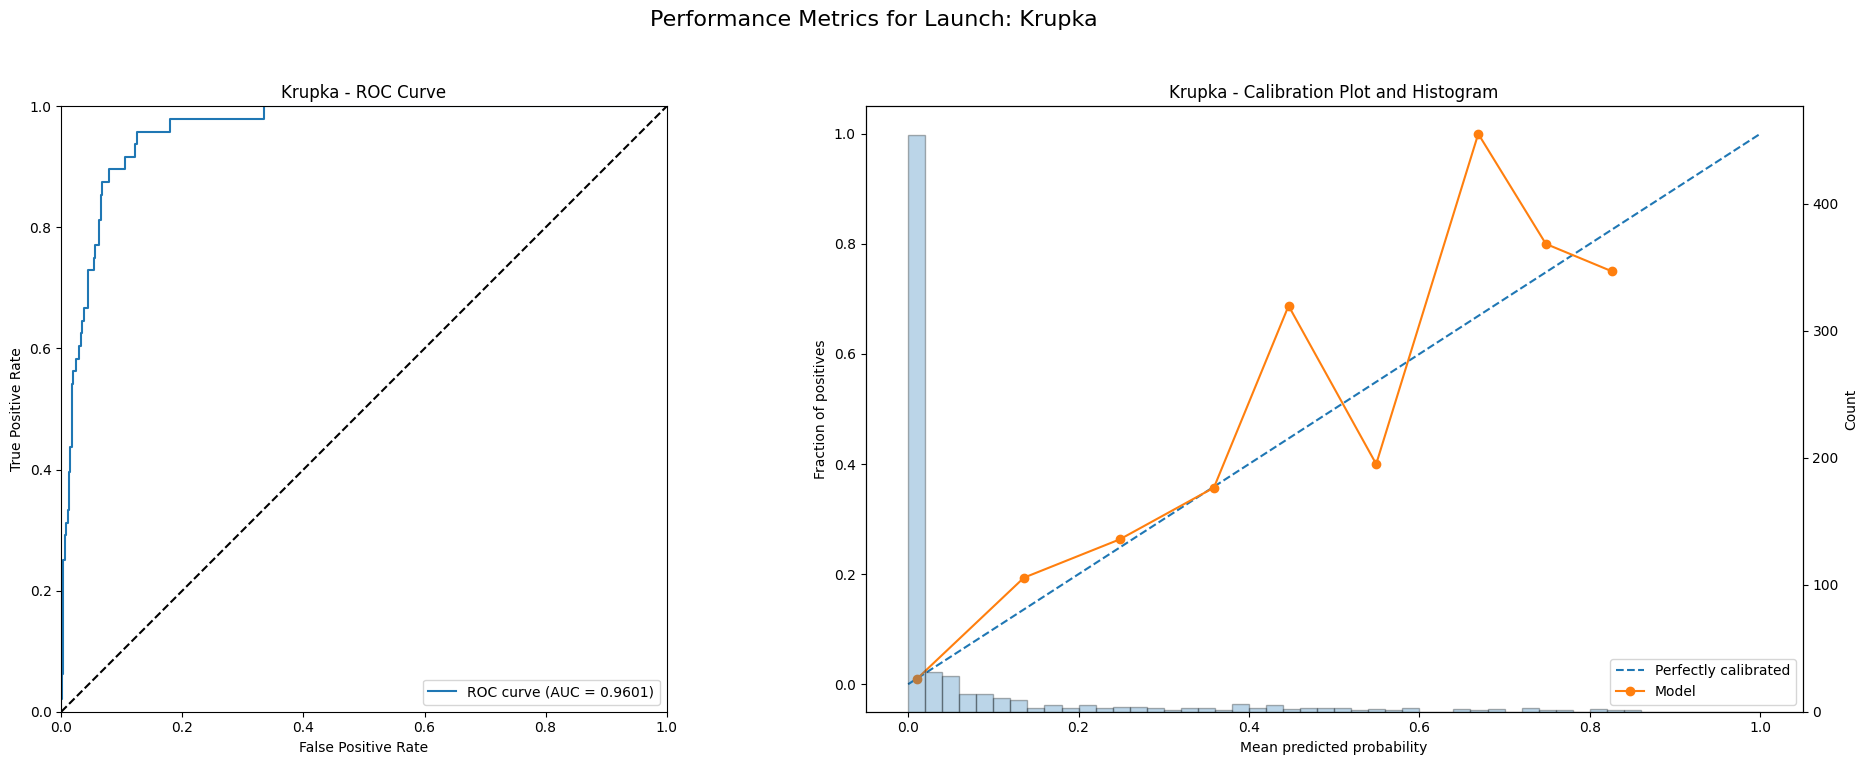

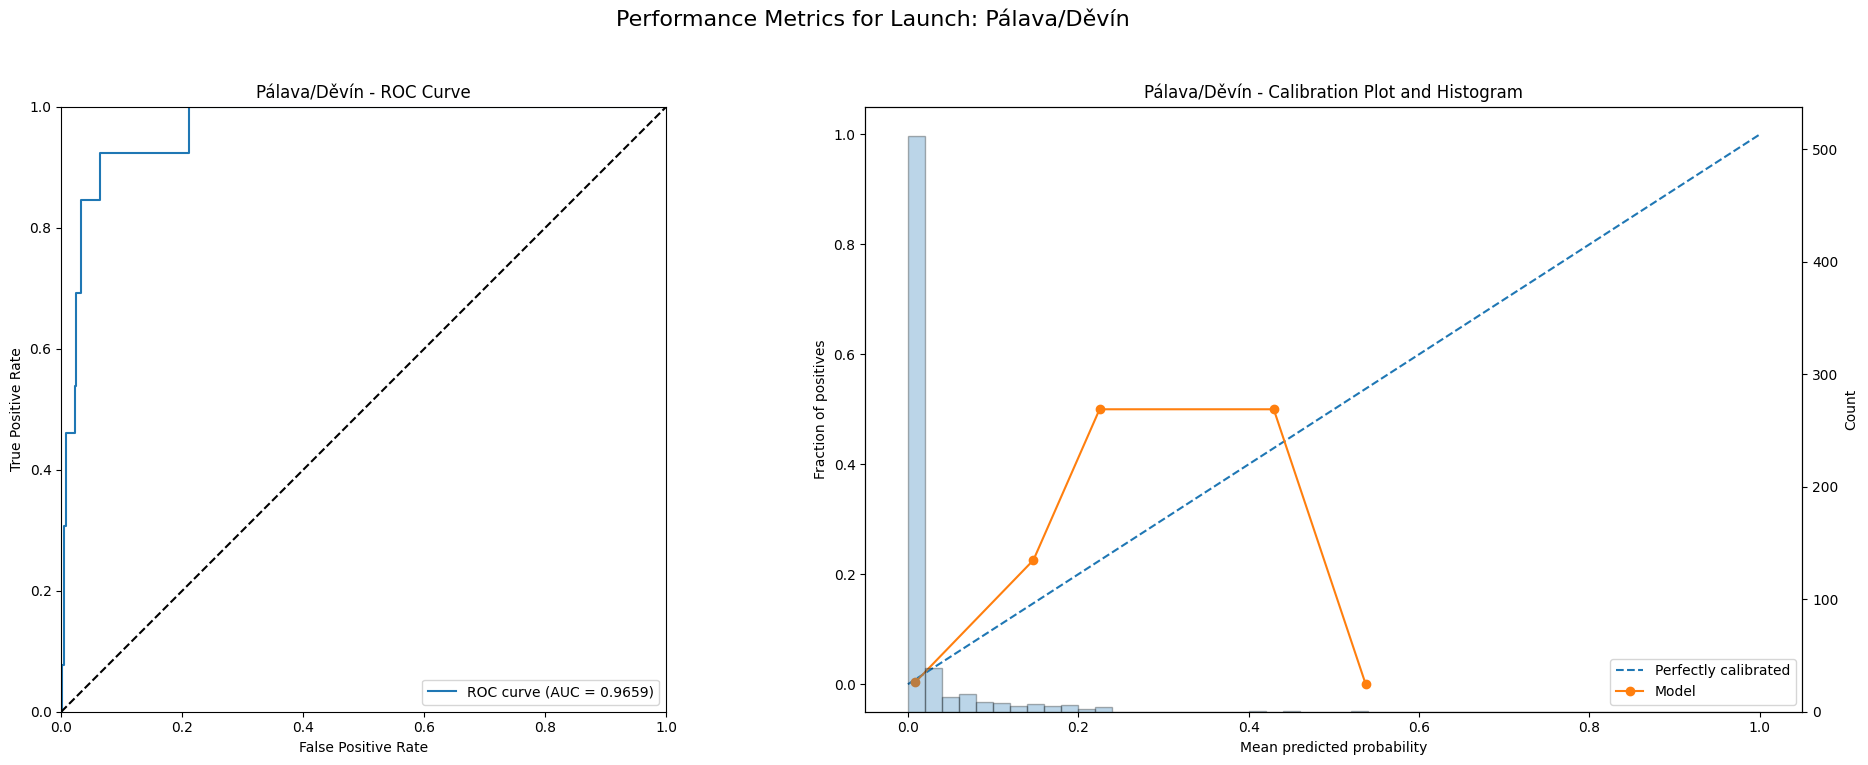

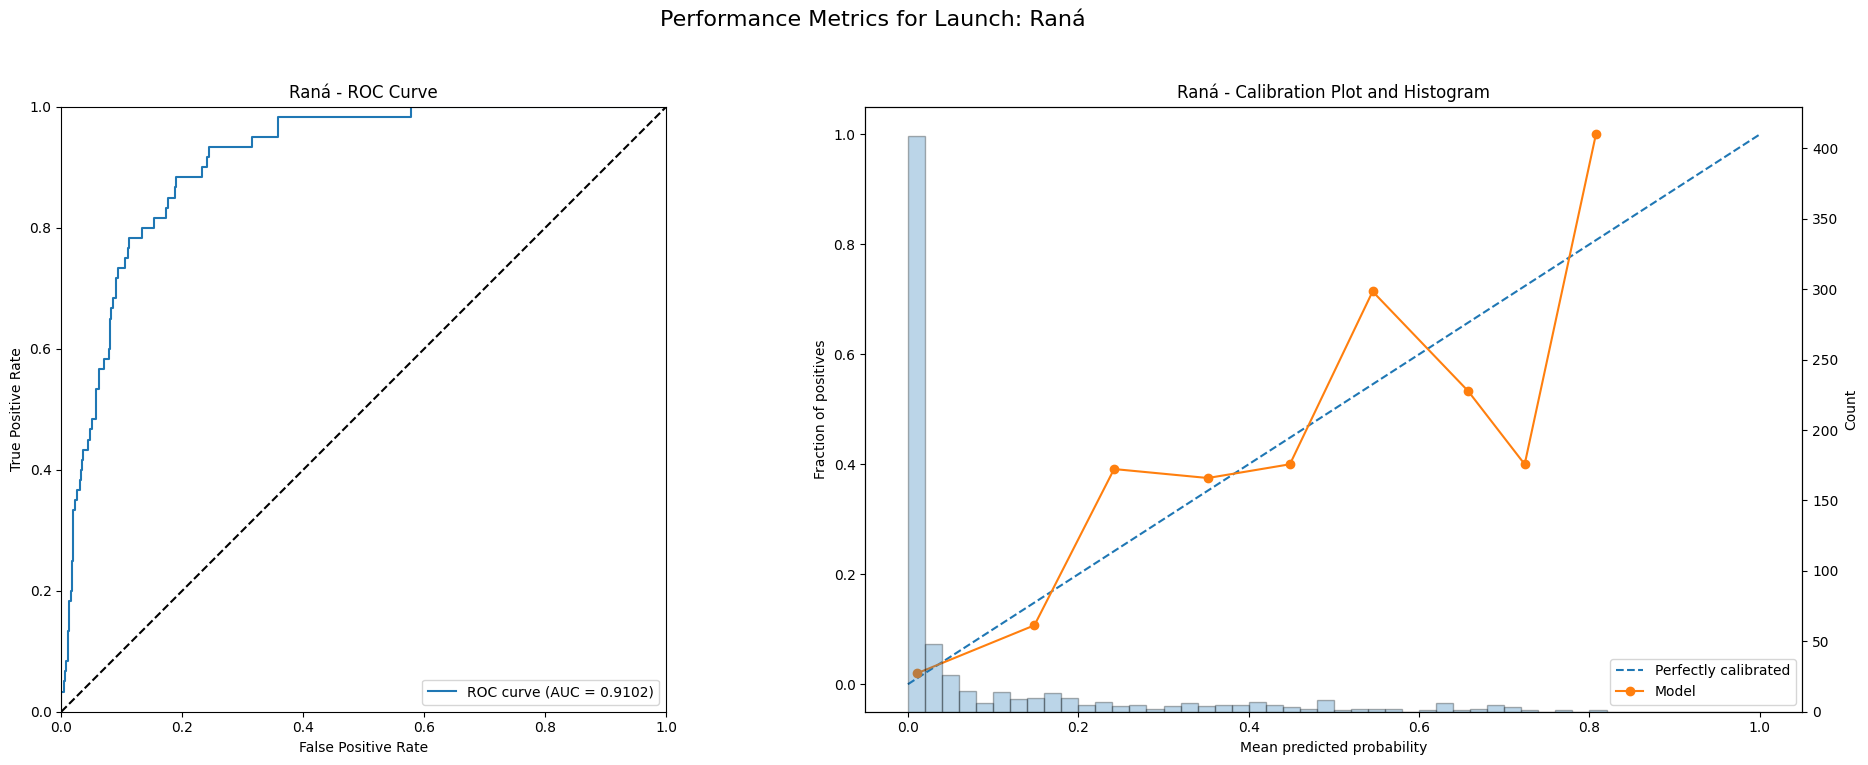

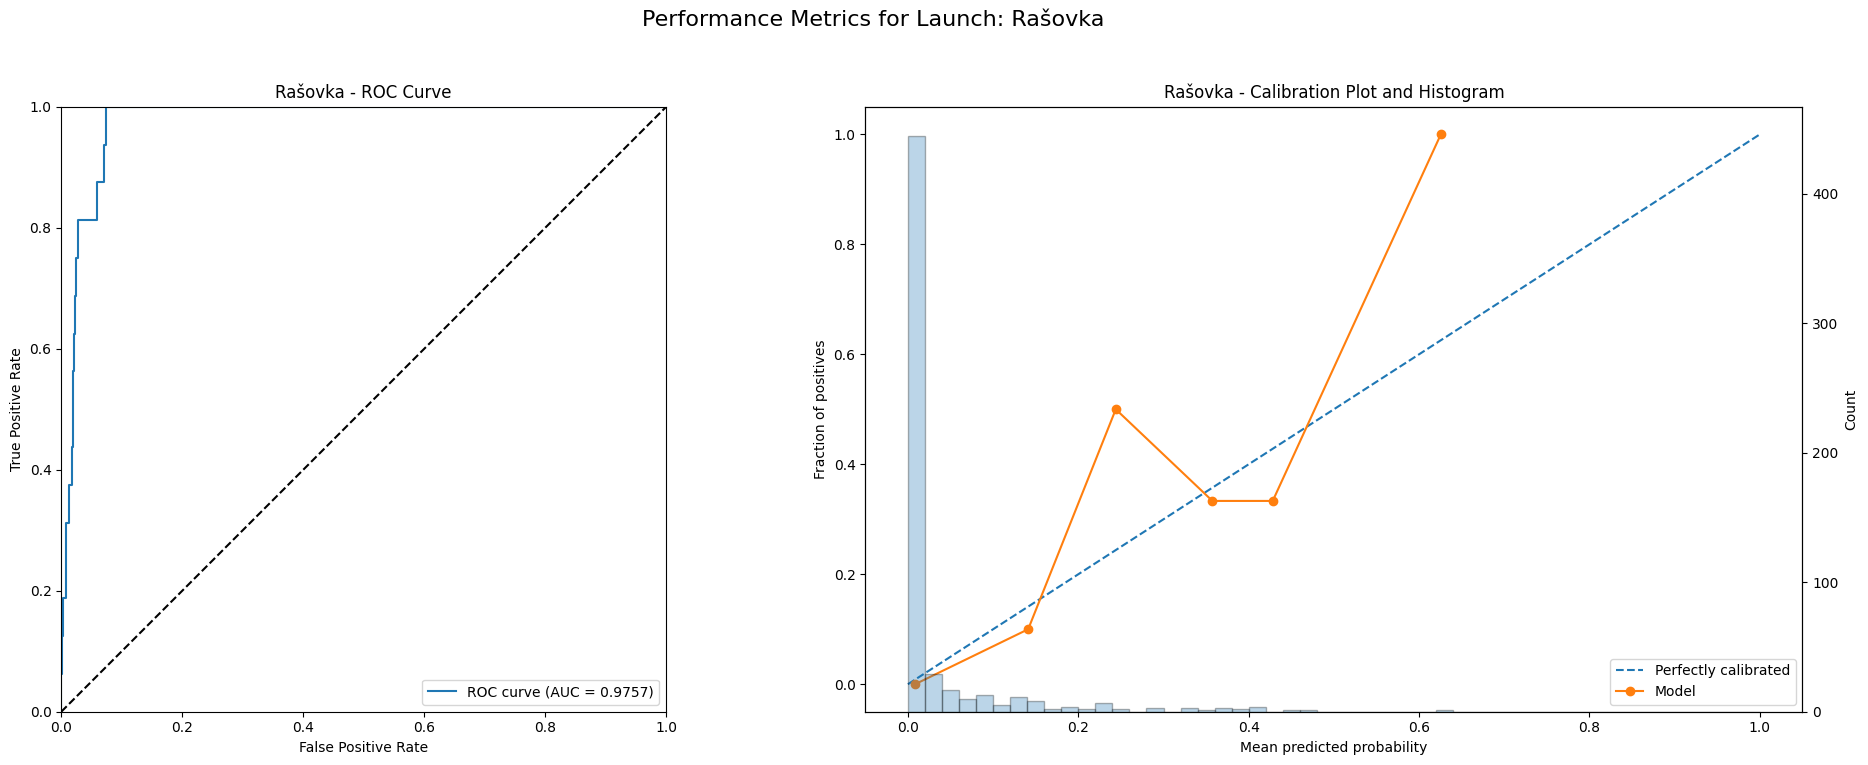

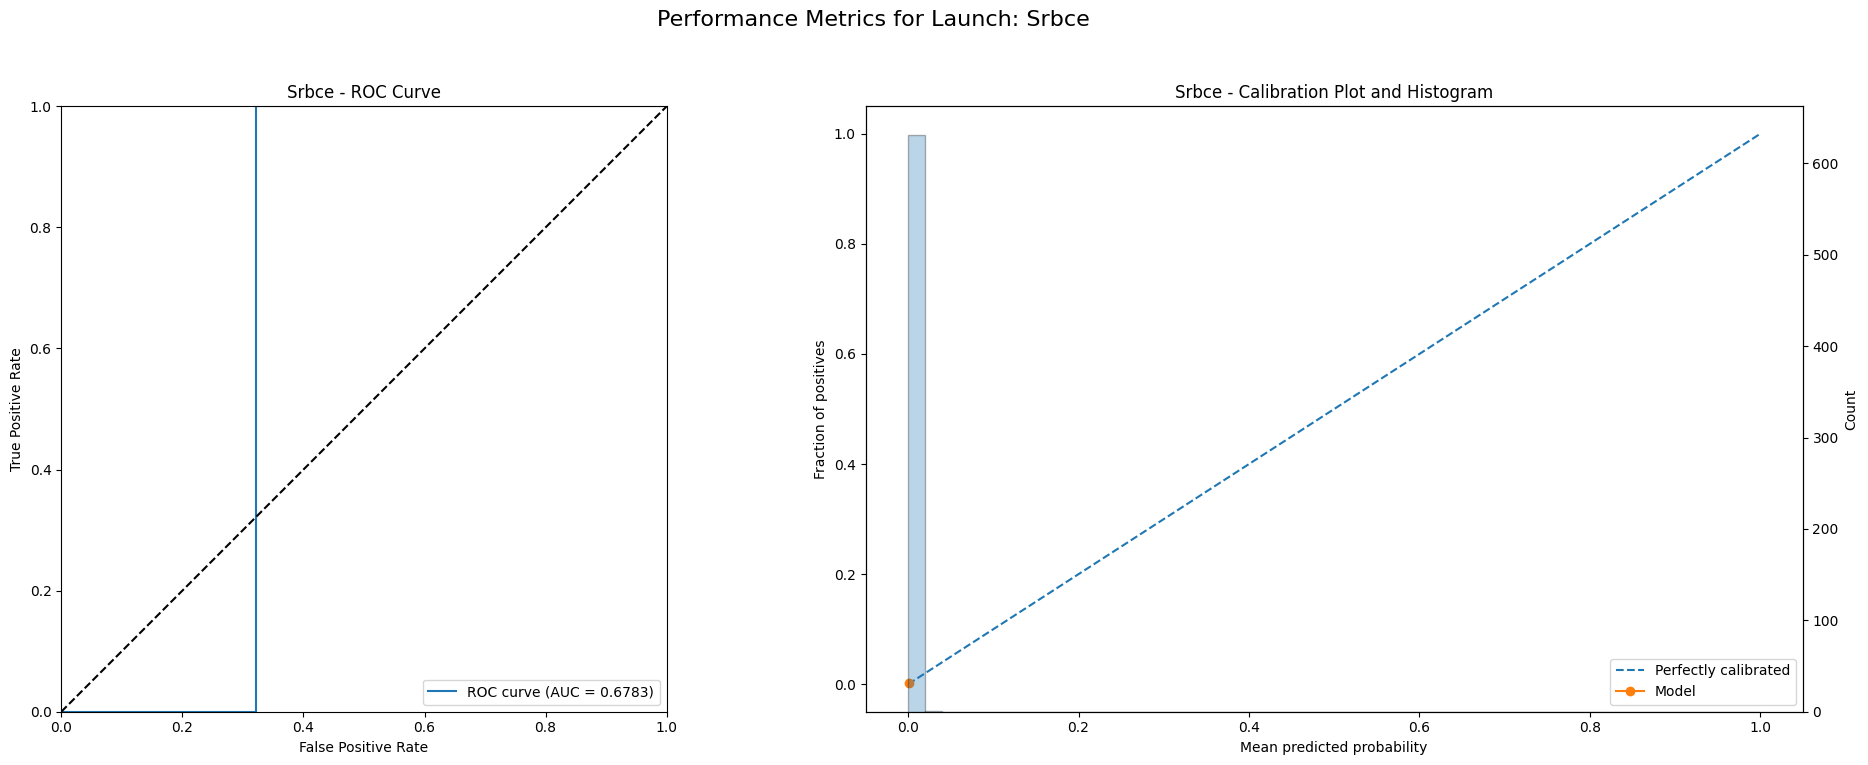

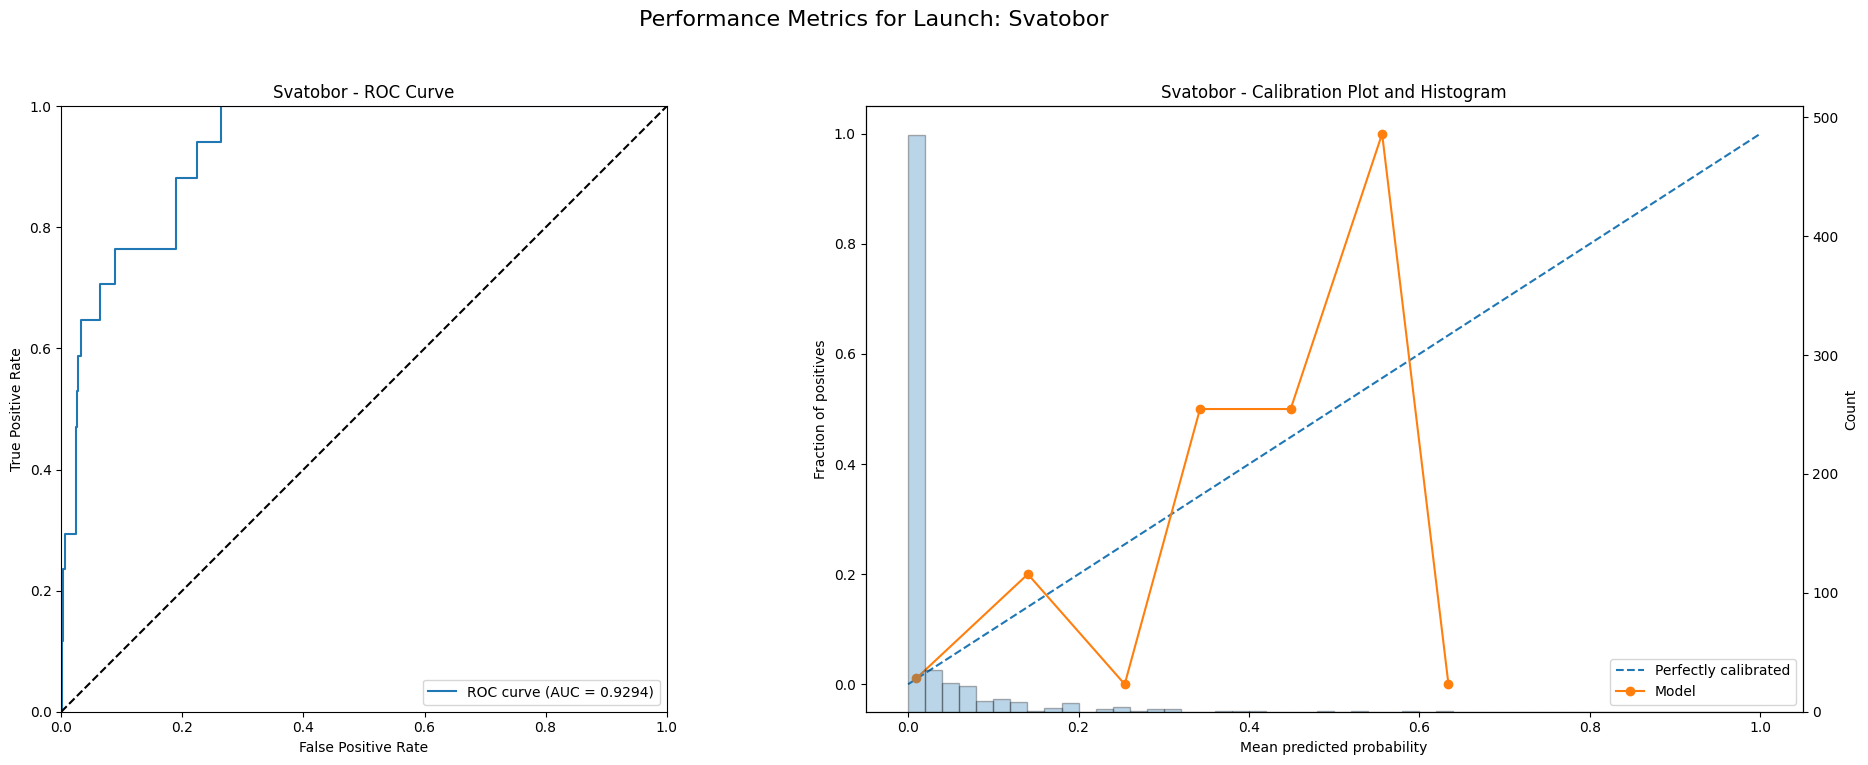

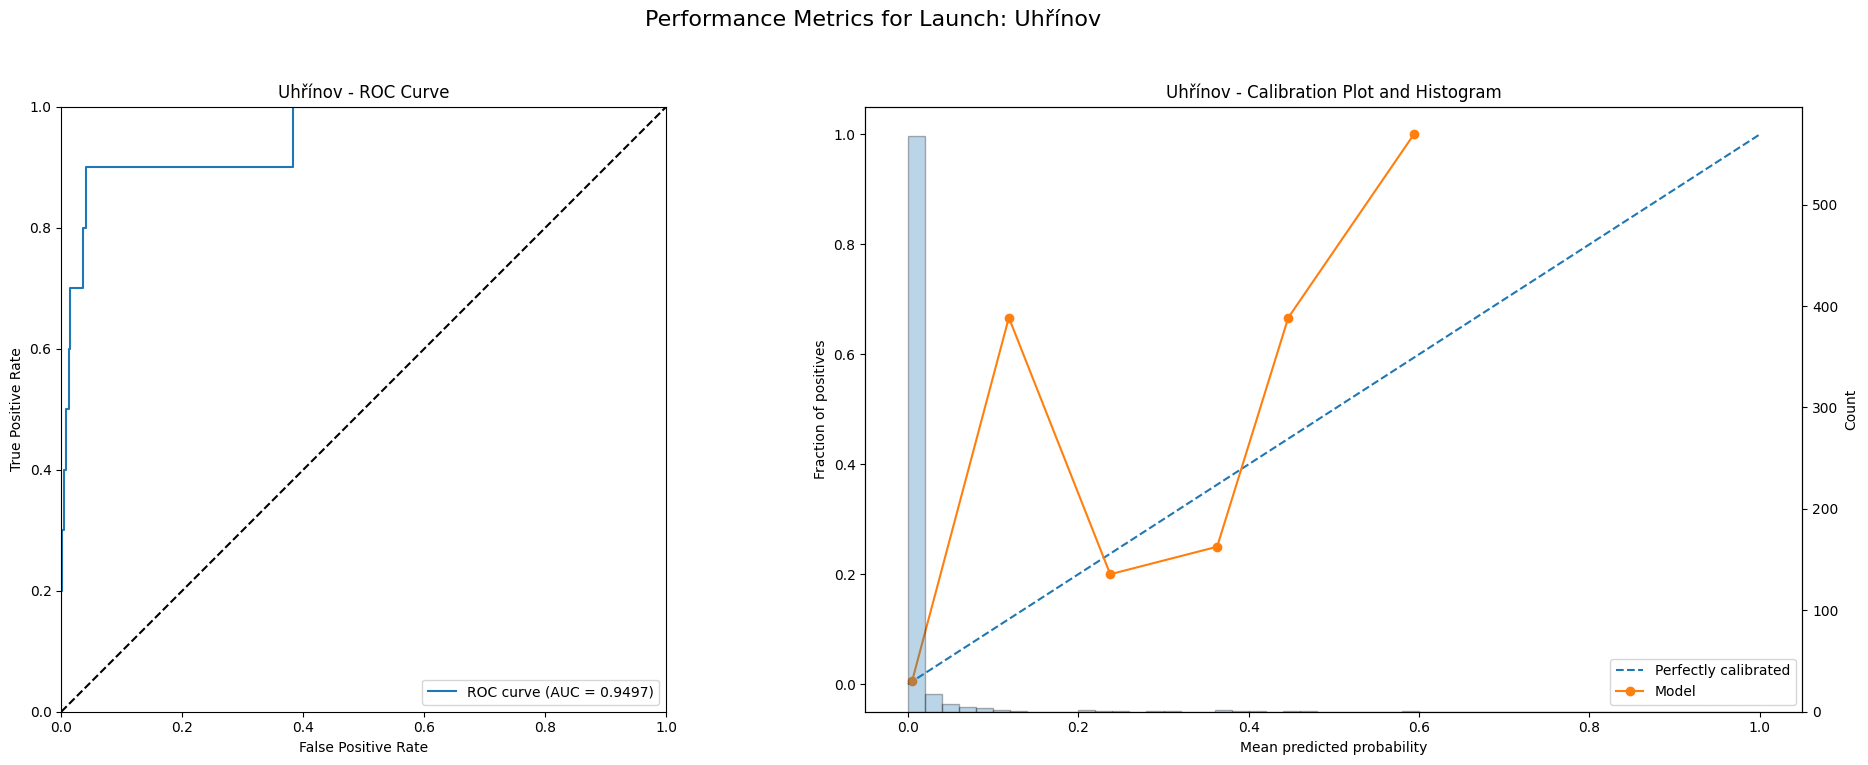

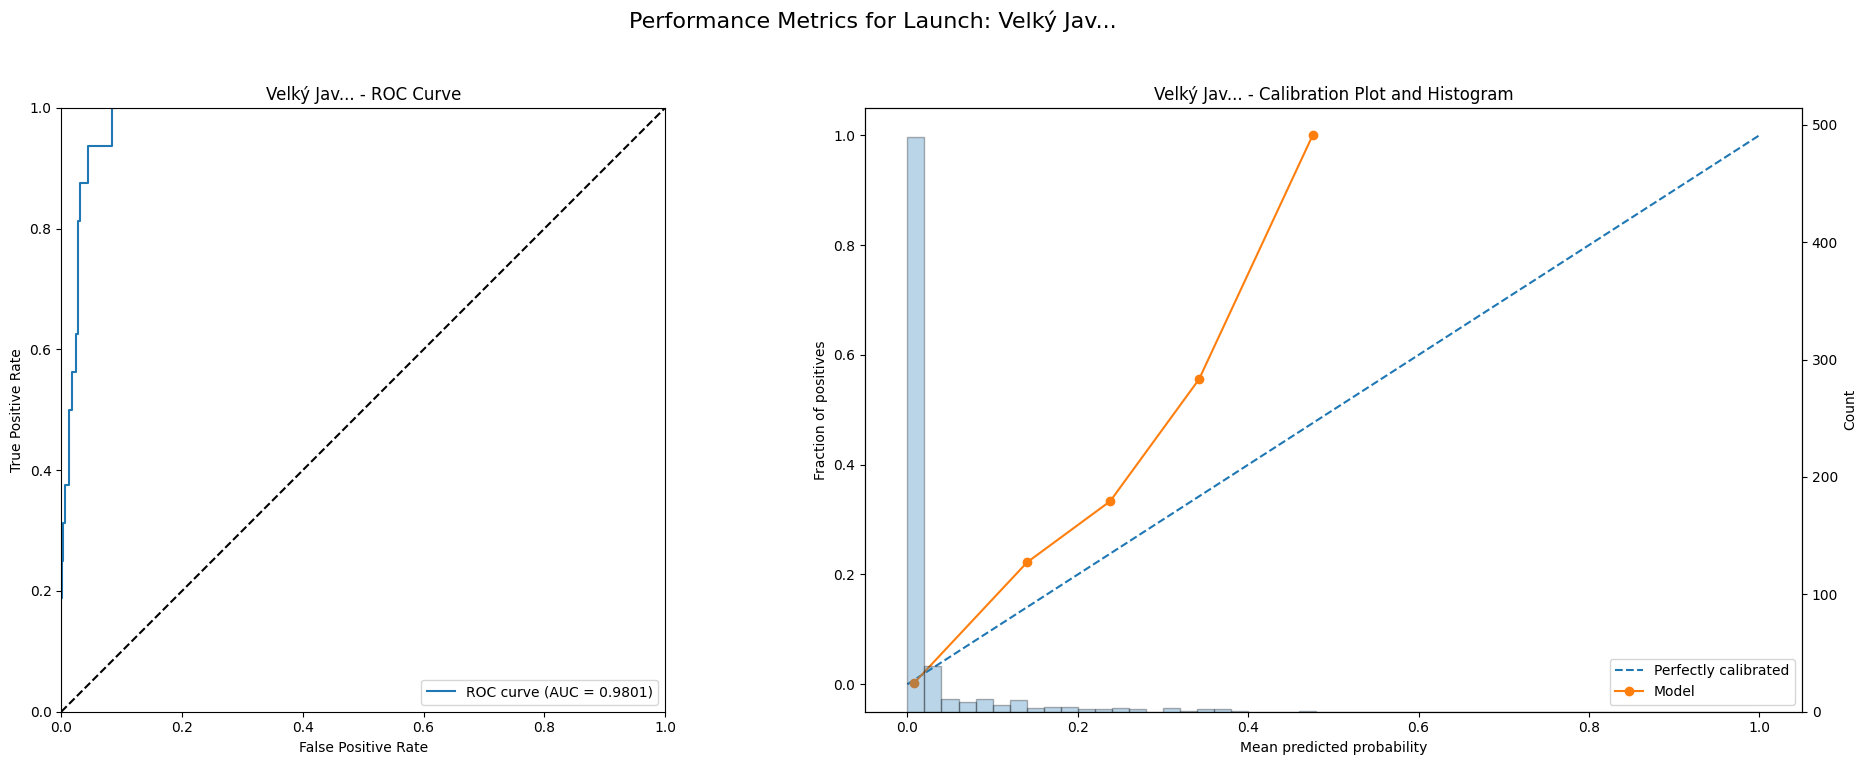

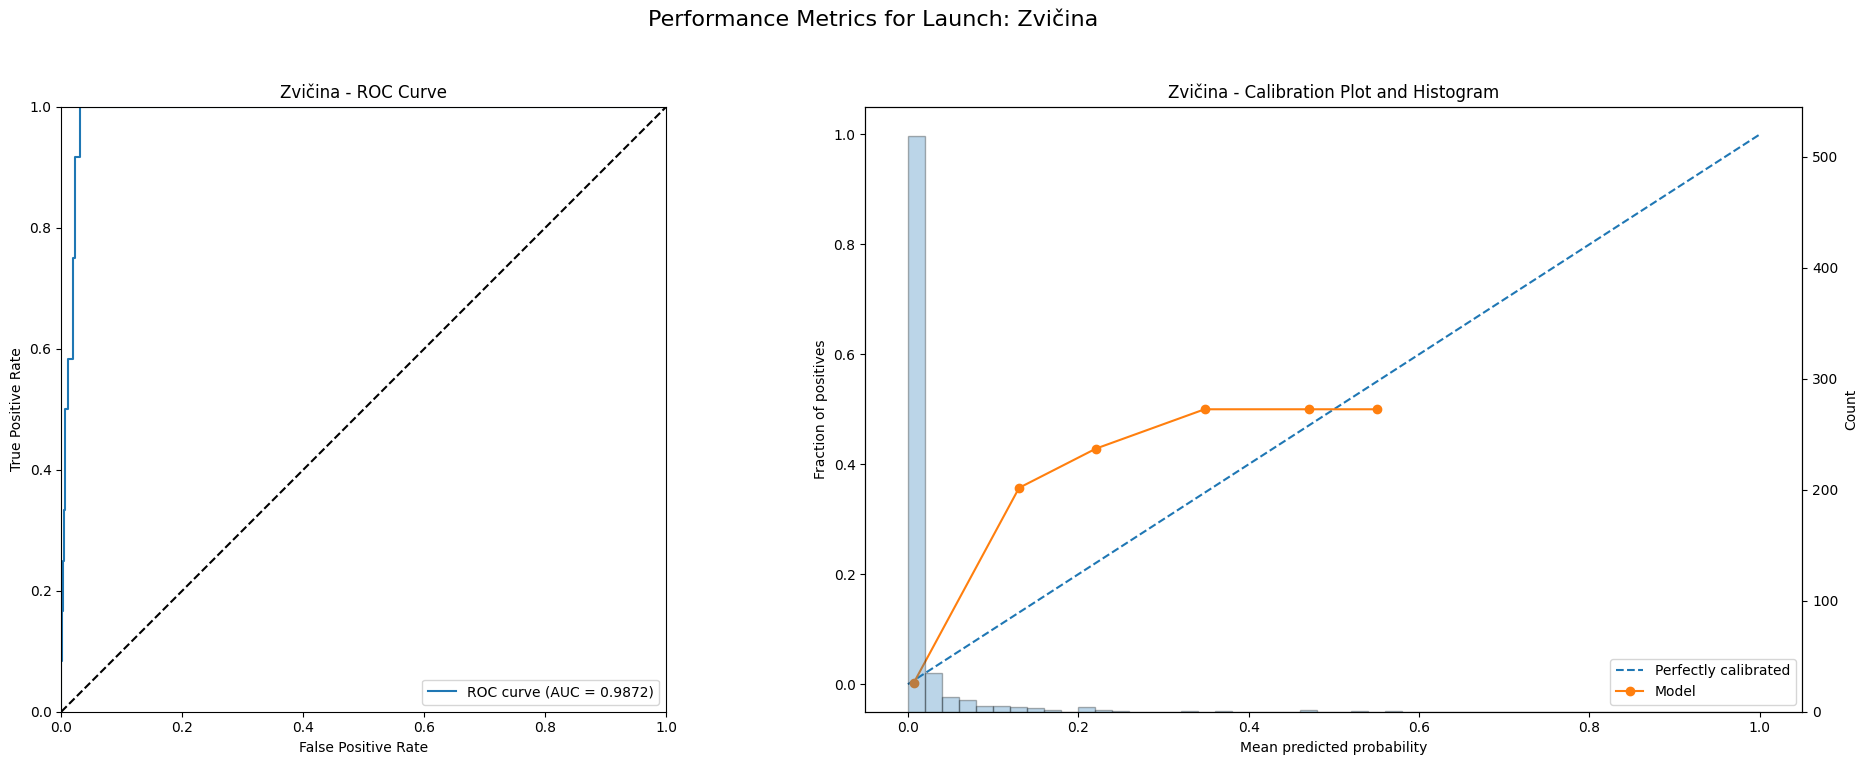

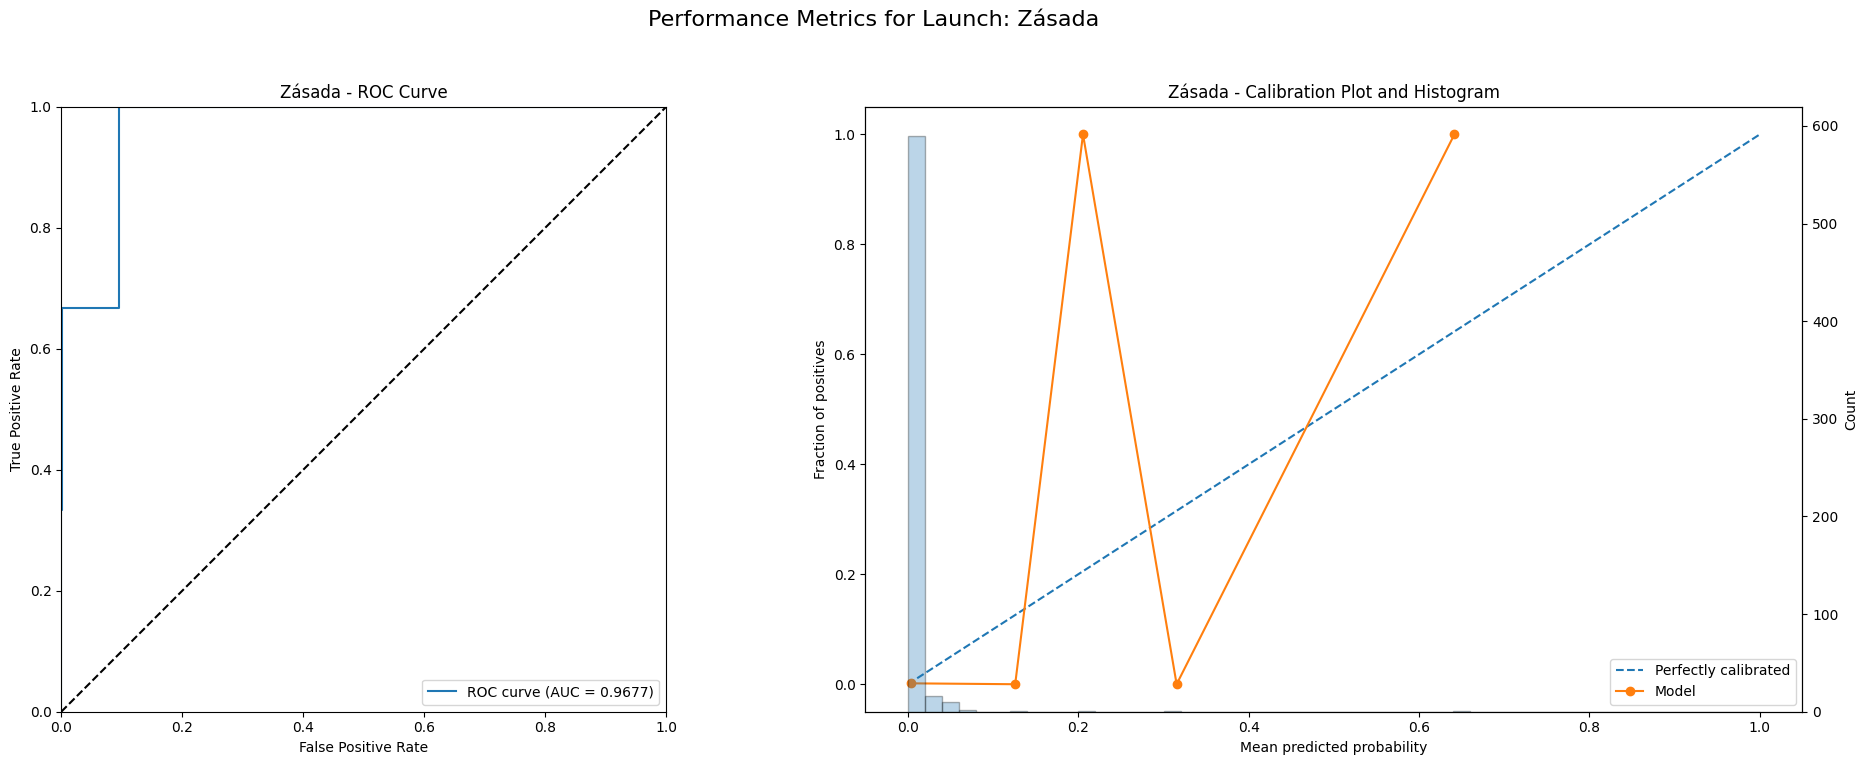

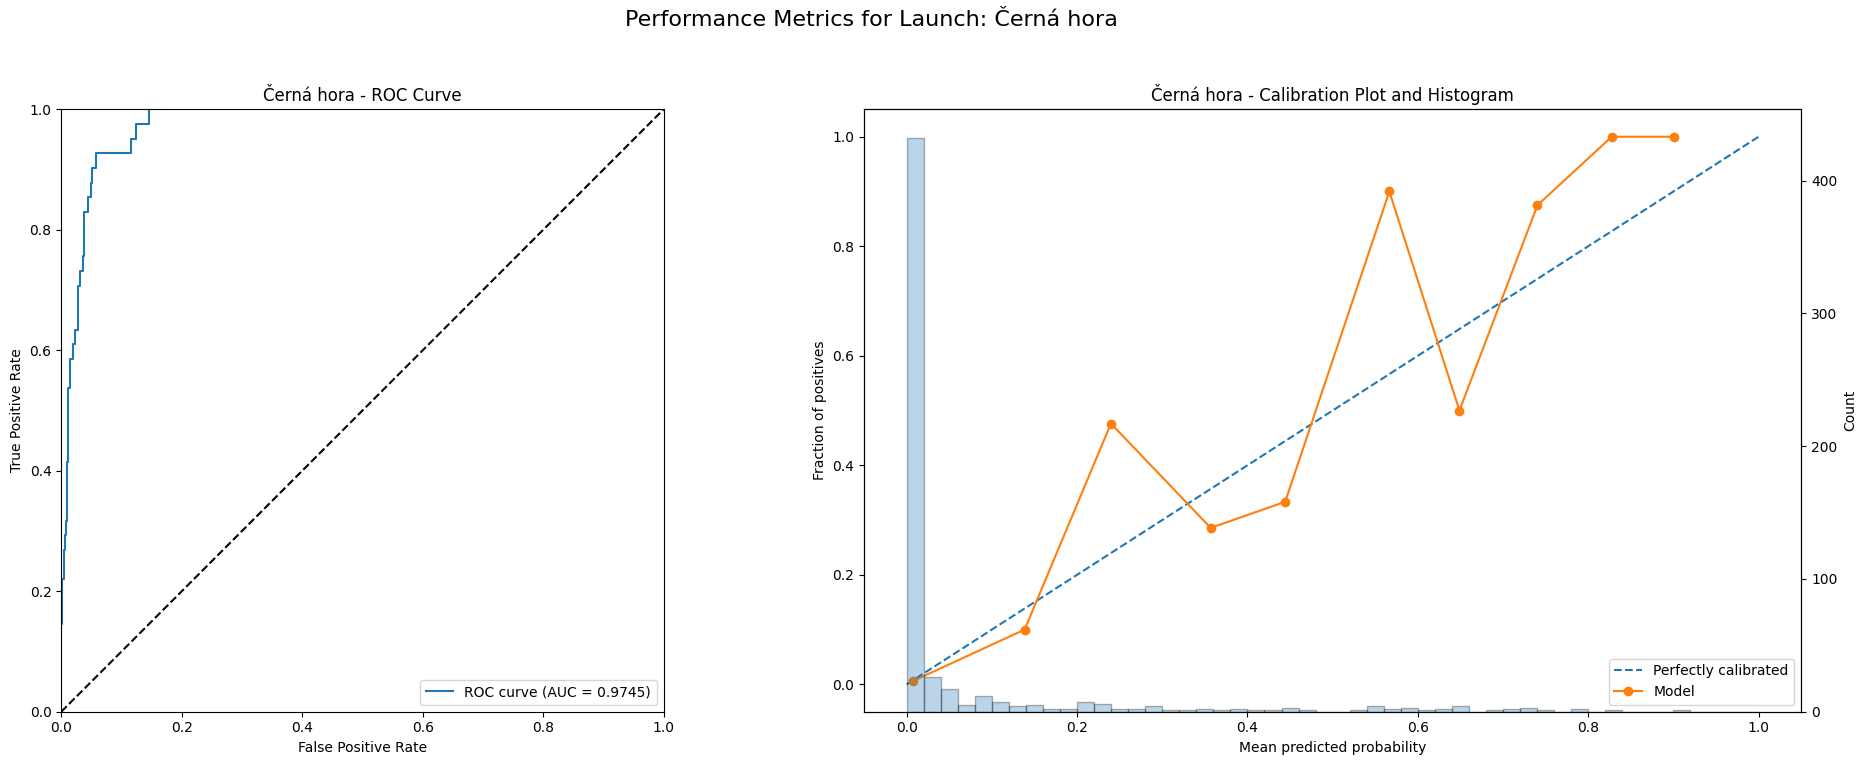

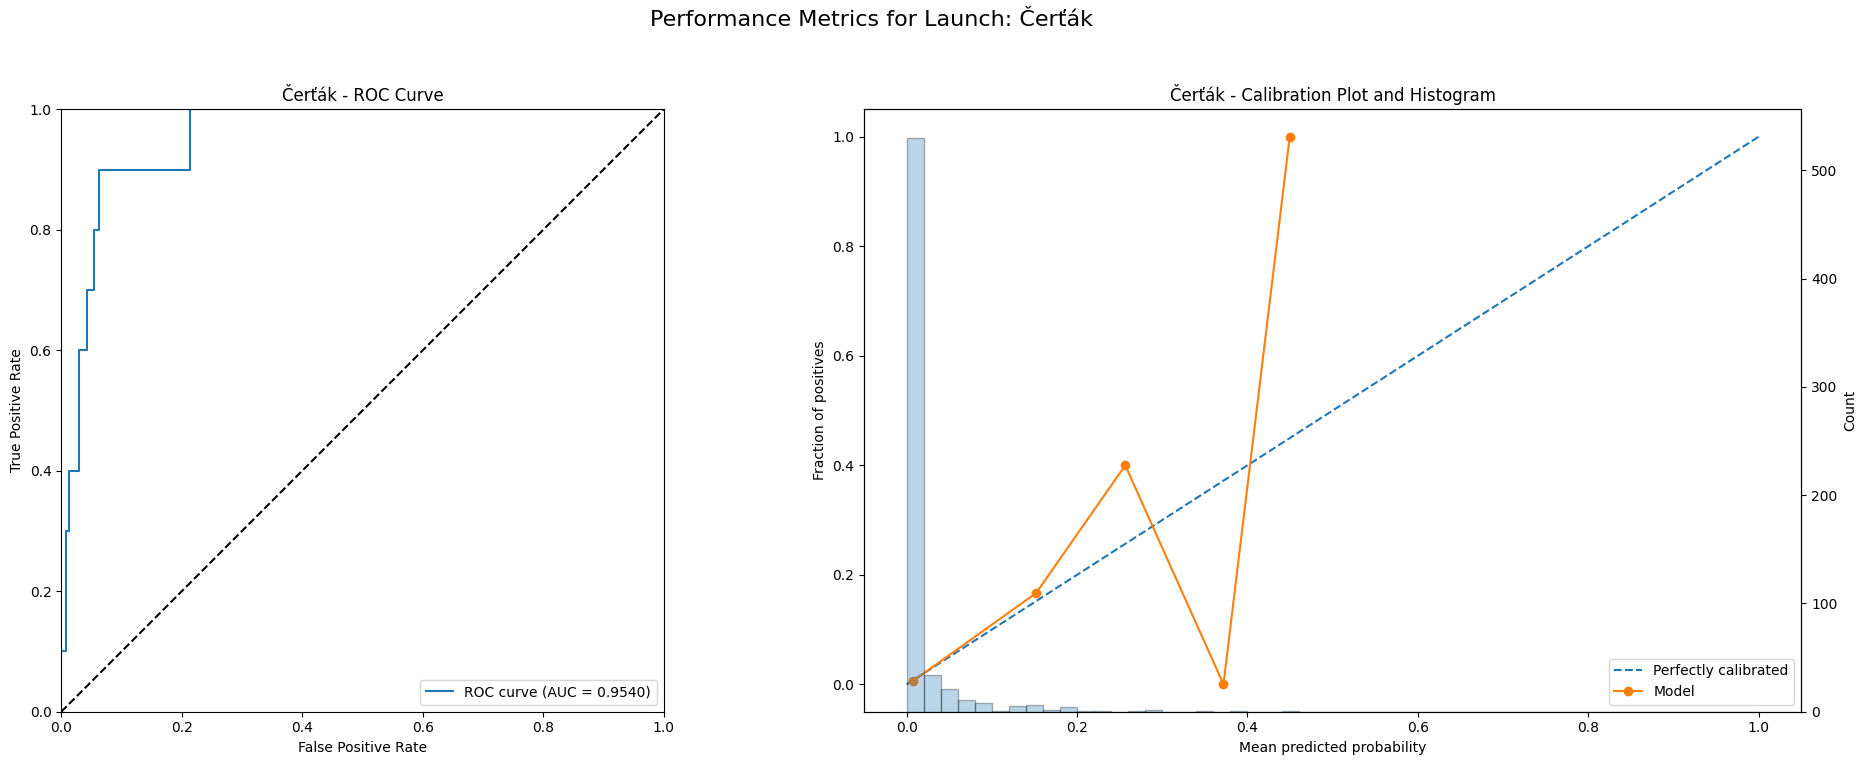

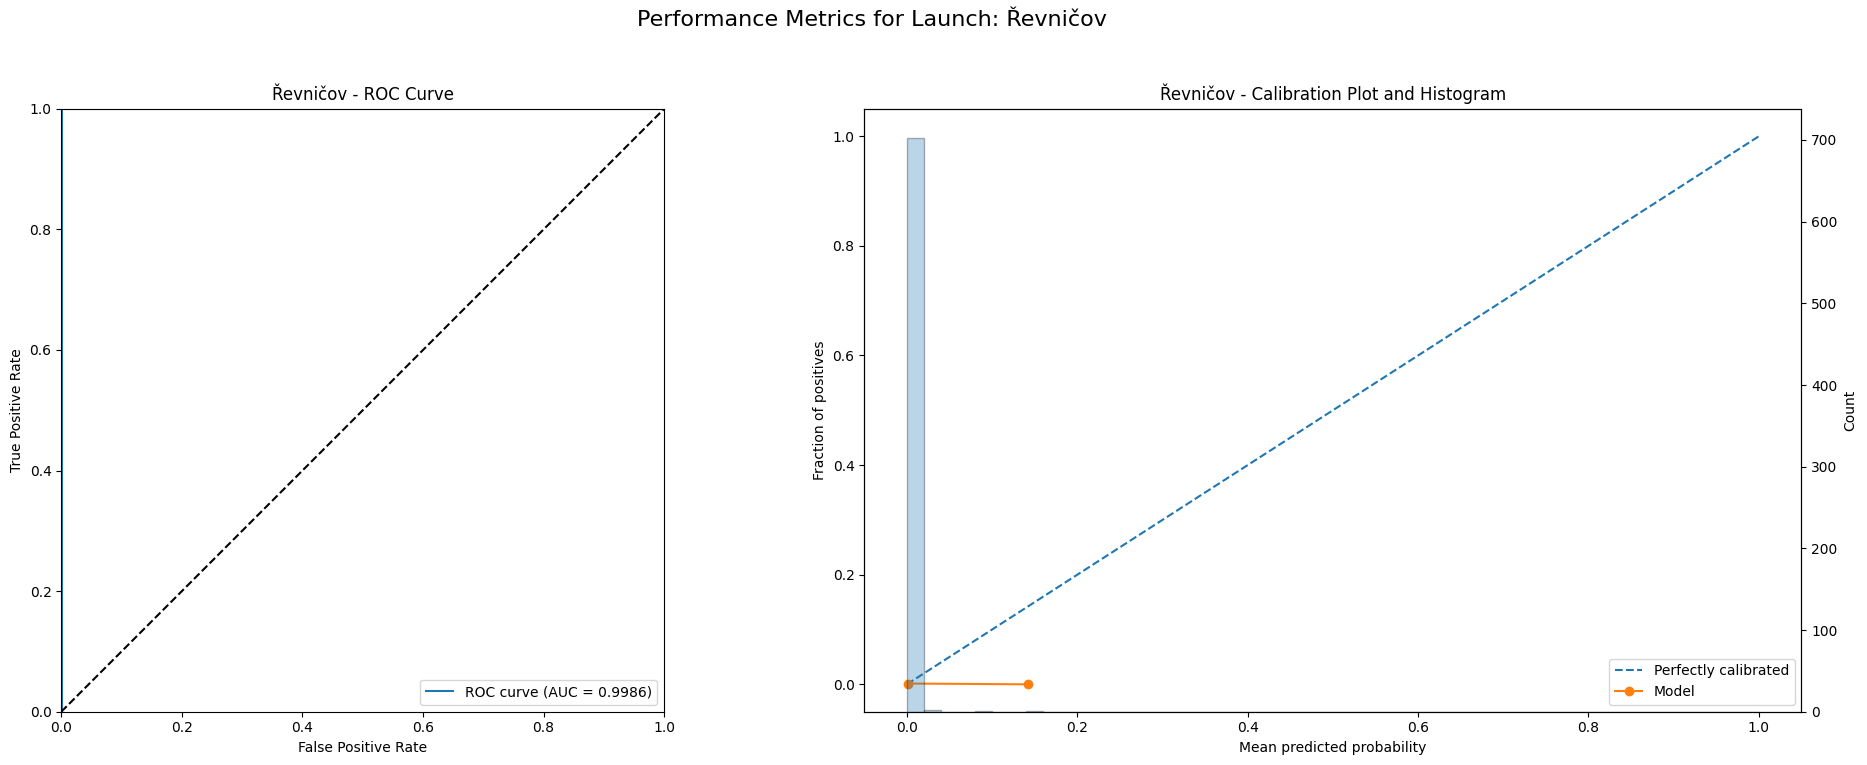

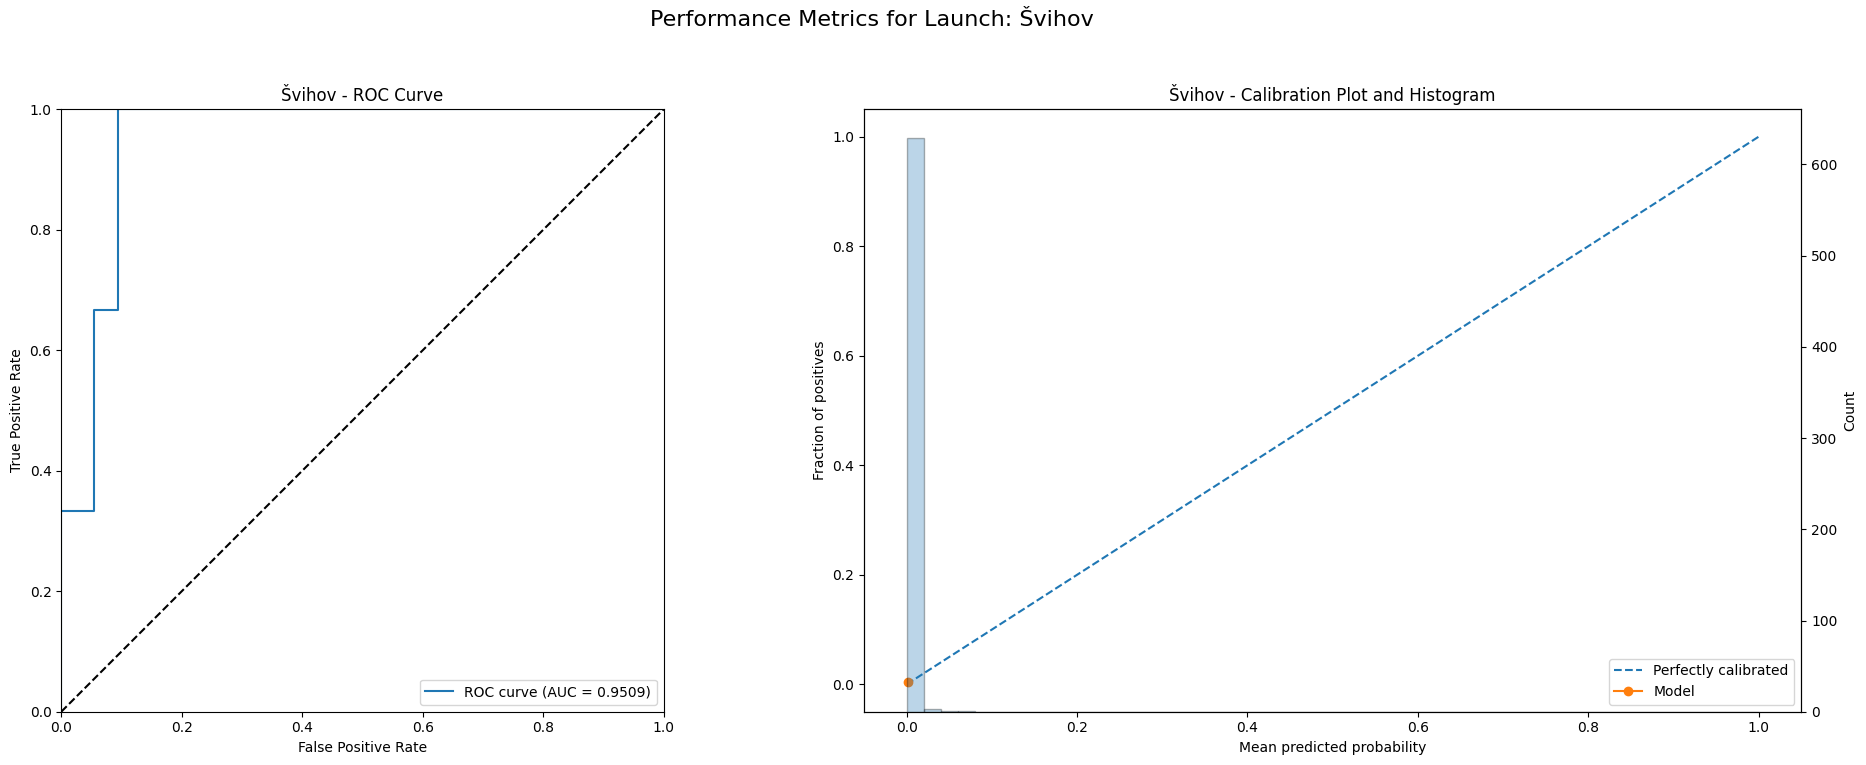

In [16]:
launches = df['launch'].unique()

for launch in launches:
    # Filter validation data for the current launch
    launch_mask = df.loc[y_val.index, 'launch'] == launch
    y_val_launch = y_val[launch_mask]
    y_pred_proba_launch = y_pred_proba[launch_mask]

    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot ROC curve on the first subplot, passing ax1
    utils.plot_roc_curve(y_val_launch, y_pred_proba_launch, ax=ax1)
    ax1.set_title(f'{launch} - ROC Curve')
    
    # Plot calibration curve and histogram on the second subplot, passing ax2
    utils.plot_calibration_and_histogram(y_val_launch, y_pred_proba_launch, ax=ax2)
    ax2.set_title(f'{launch} - Calibration Plot and Histogram')
    
    # Set the main title for the figure
    fig.suptitle(f'Performance Metrics for Launch: {launch}', fontsize=16)
    
    # Adjust layout and display the figure
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()




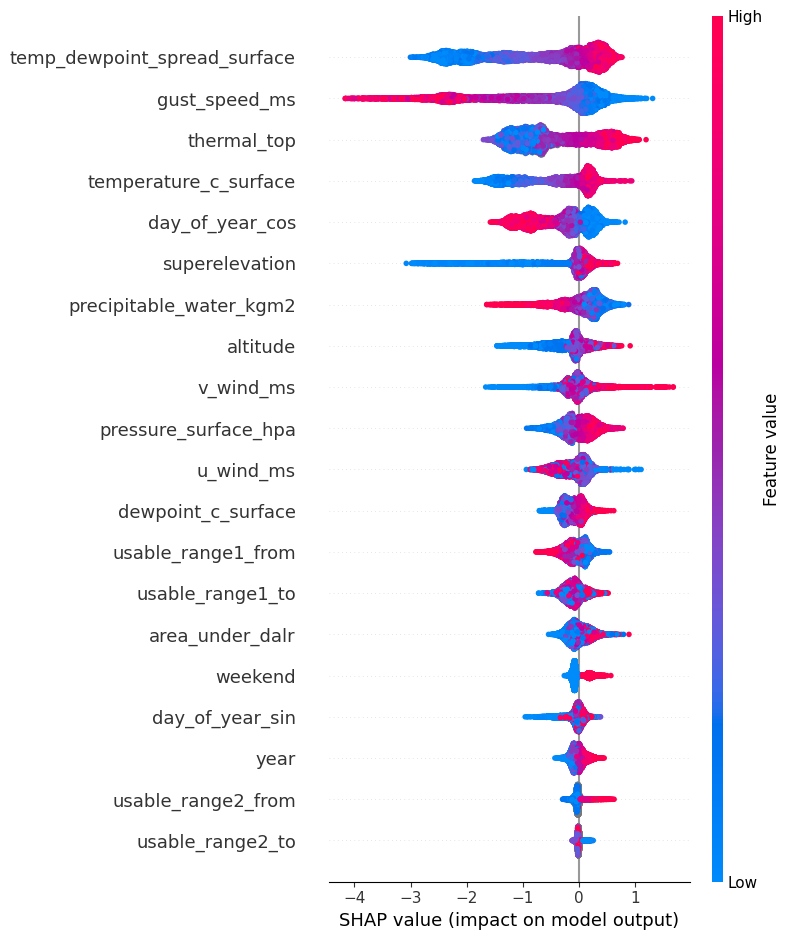

In [17]:
explainer = shap.Explainer(model)
shap_values = explainer(X_val[FEATURES])
shap.summary_plot(shap_values, X_val[FEATURES])

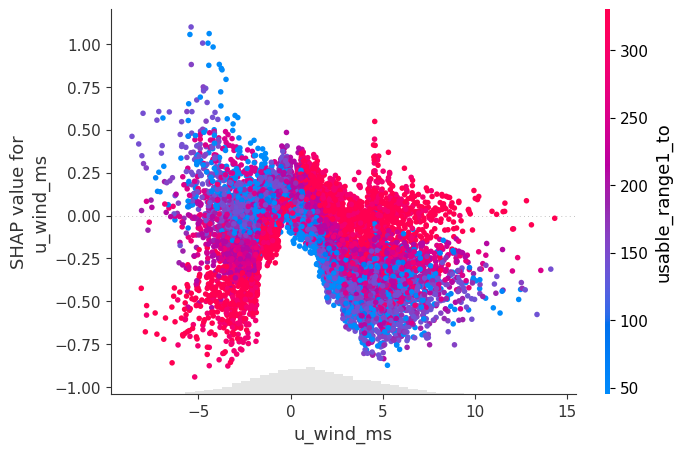

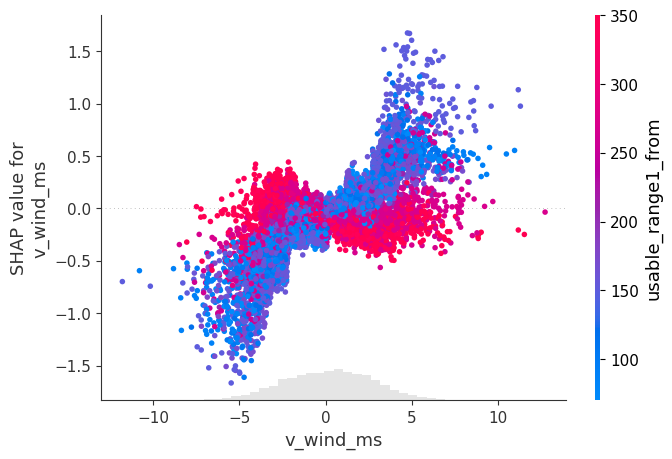

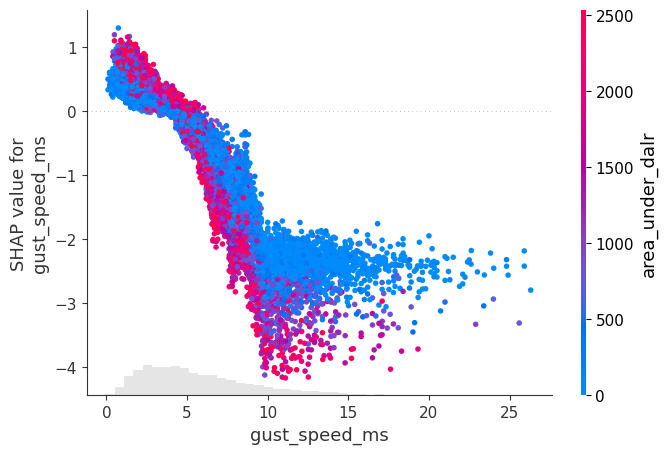

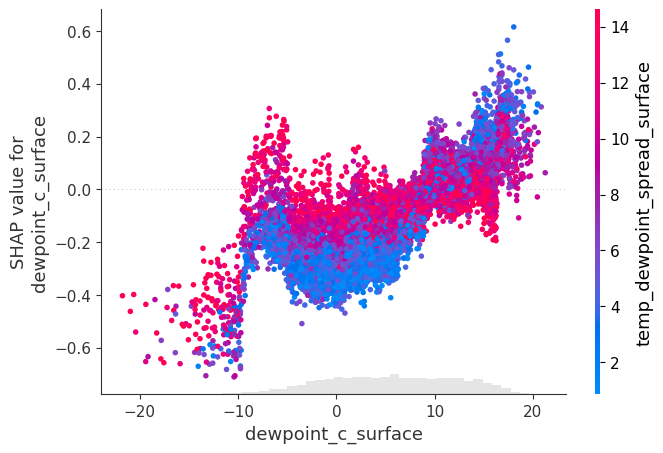

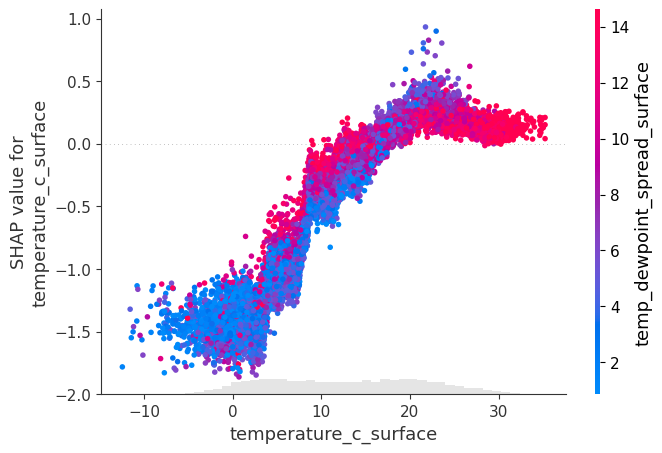

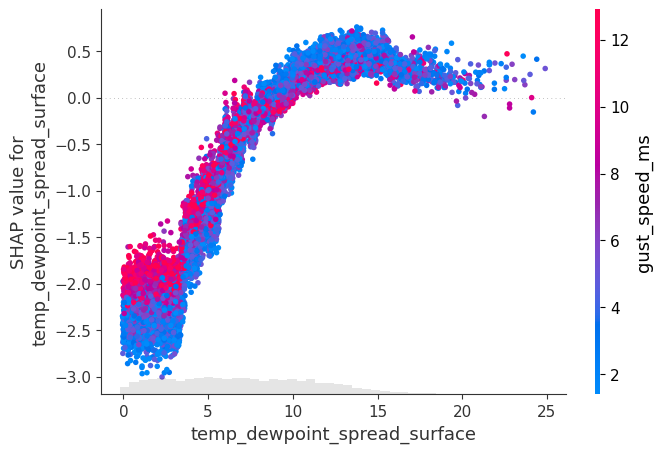

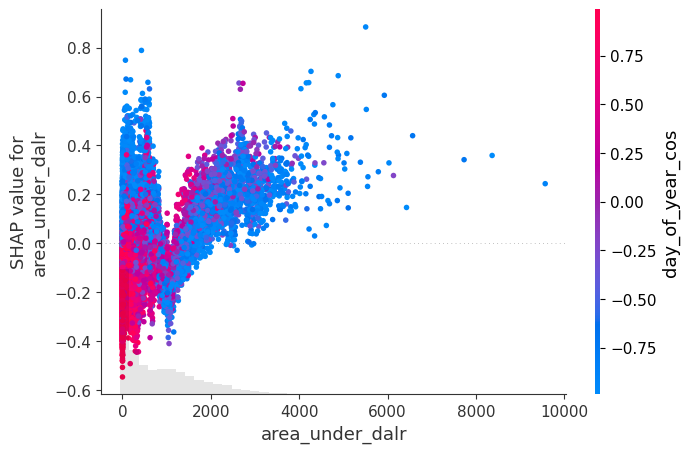

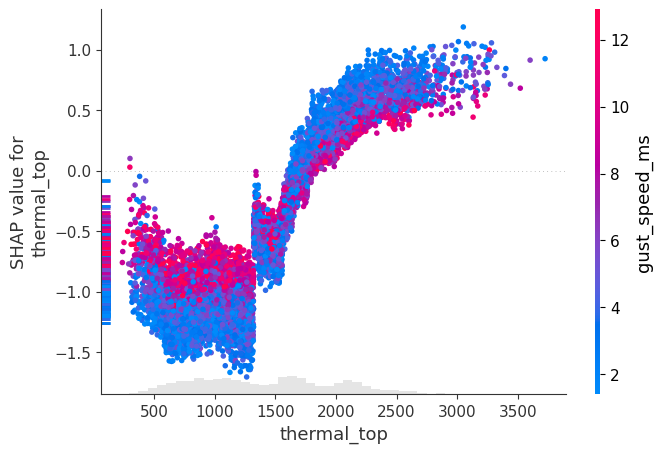

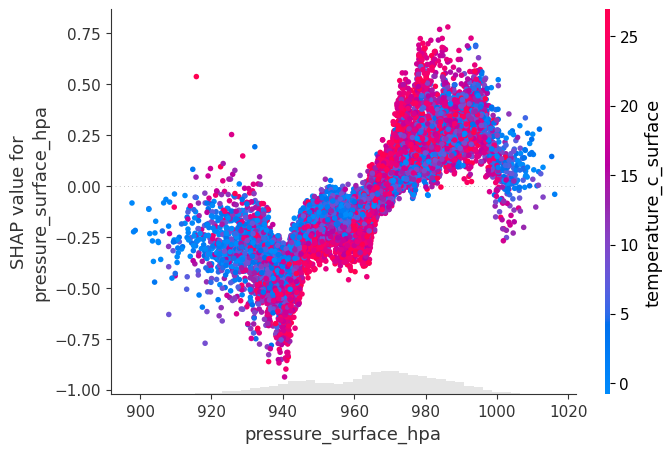

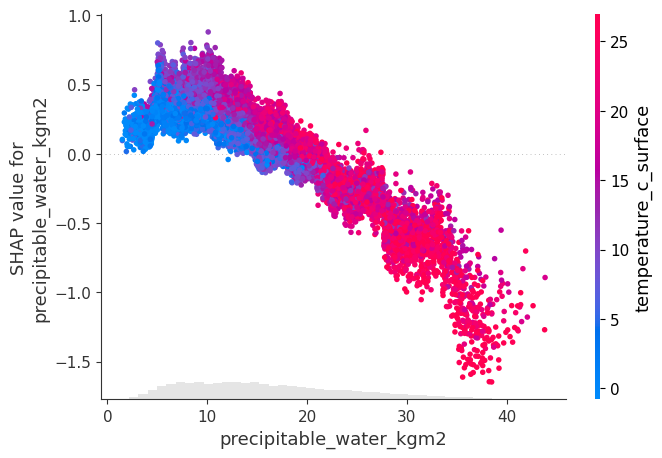

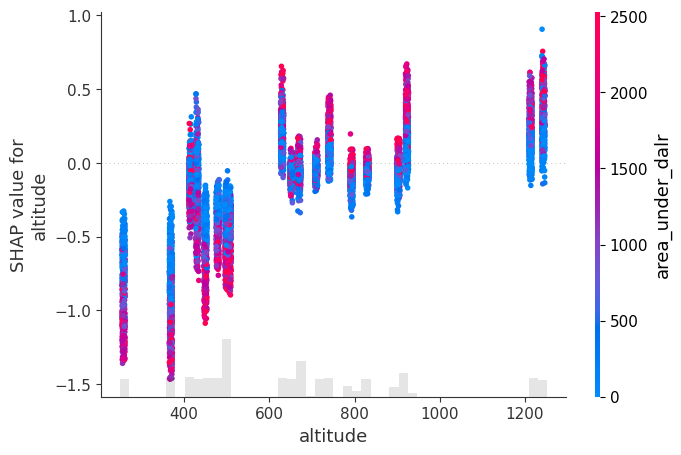

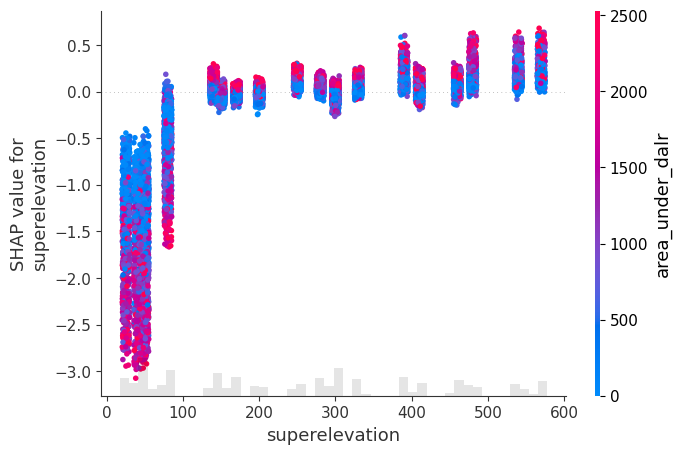

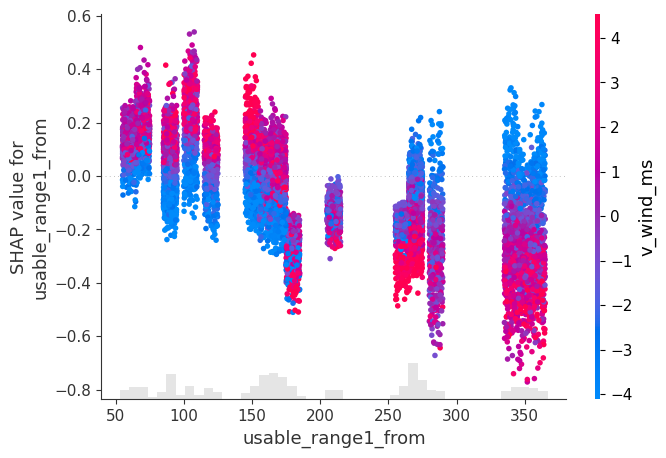

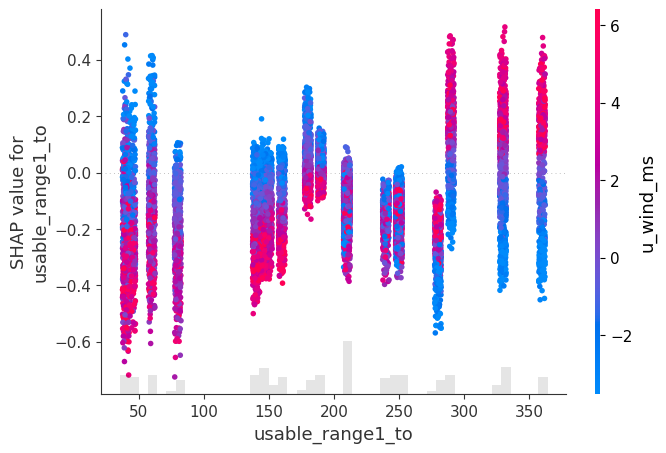

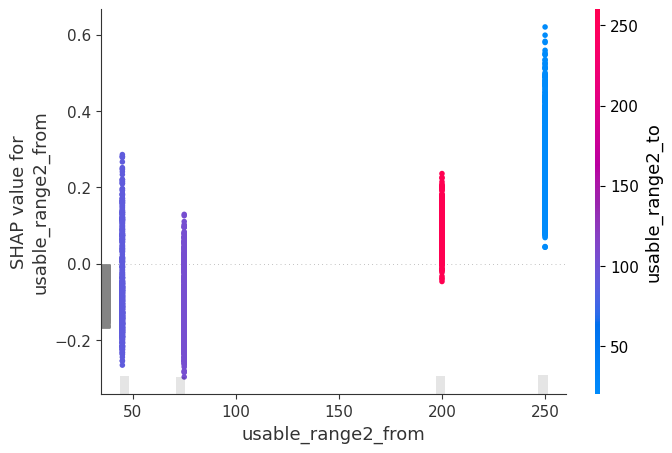

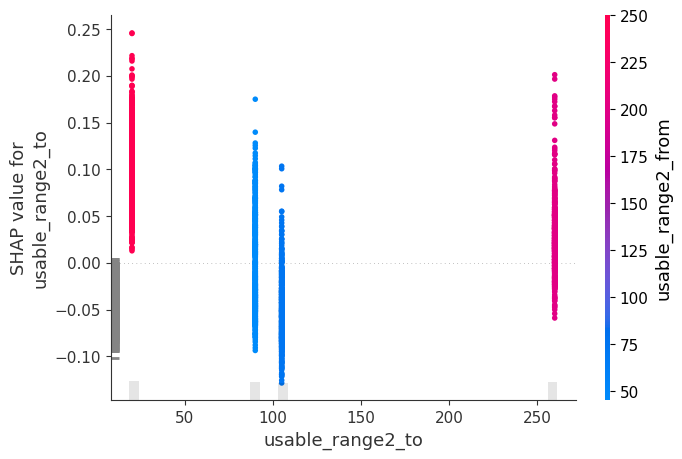

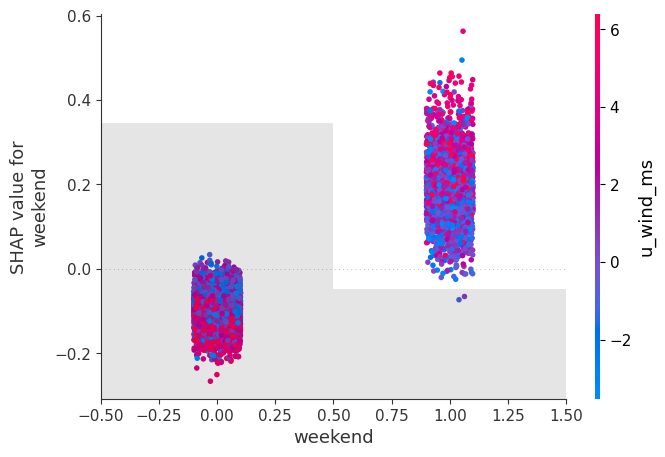

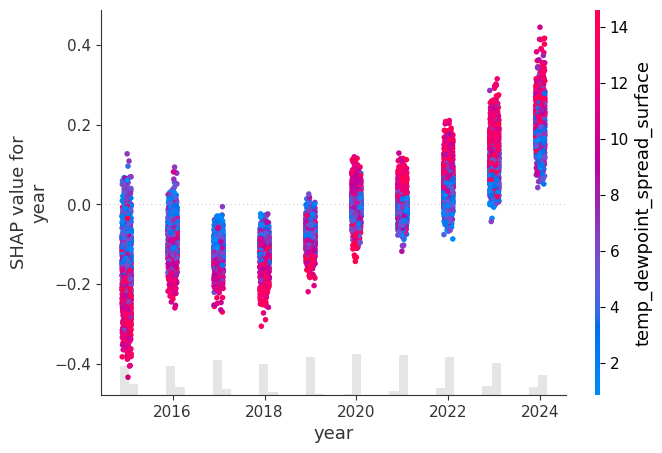

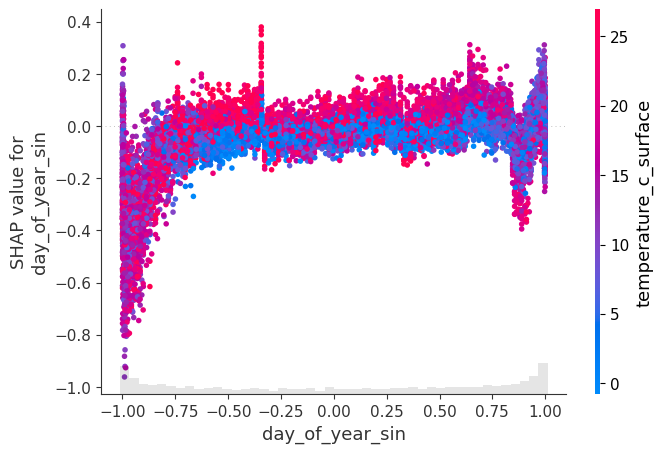

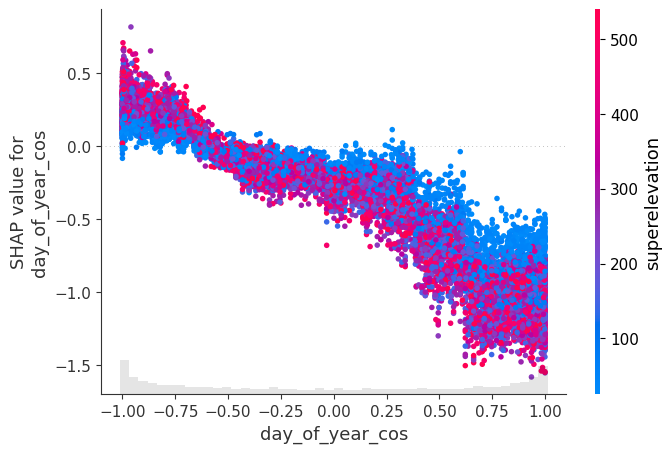

In [18]:
for feature in FEATURES:
    if feature == 'launch':
        continue
    shap.plots.scatter(shap_values[:, feature], color=shap_values)
    plt.show()

/mnt/c/Users/janhe/OneDrive/Plocha/repos/glideator/analytics/utils.py:276: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


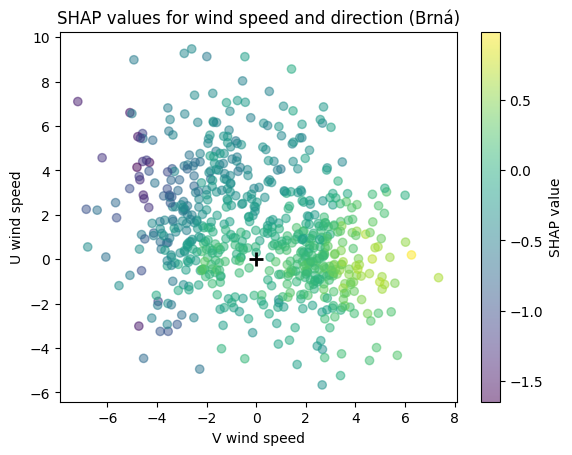

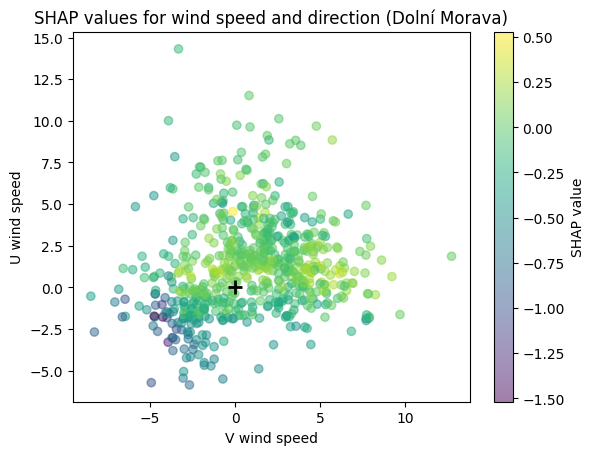

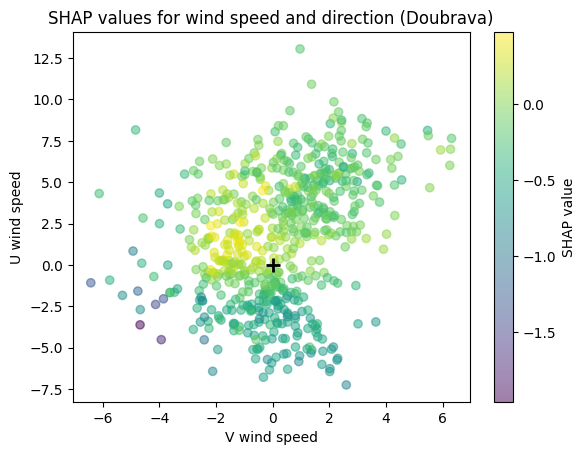

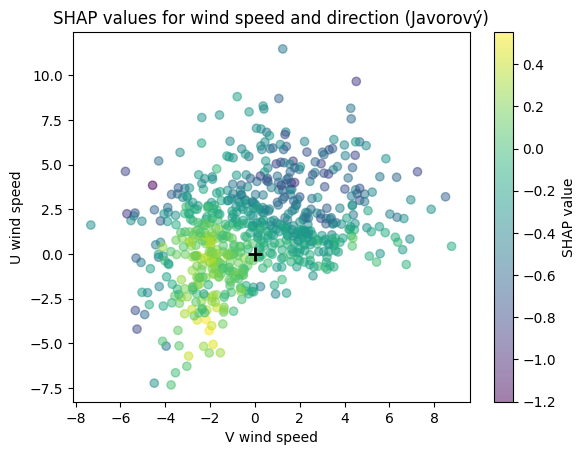

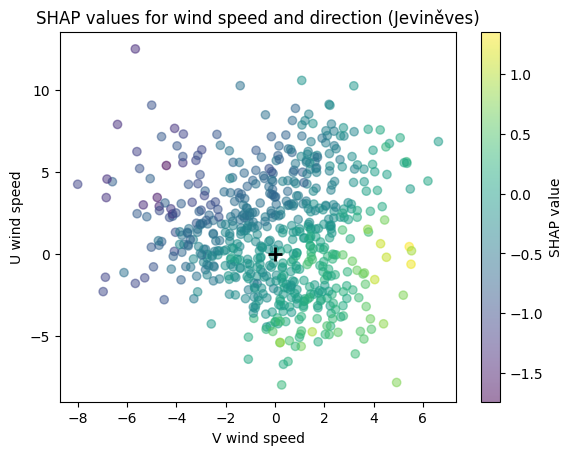

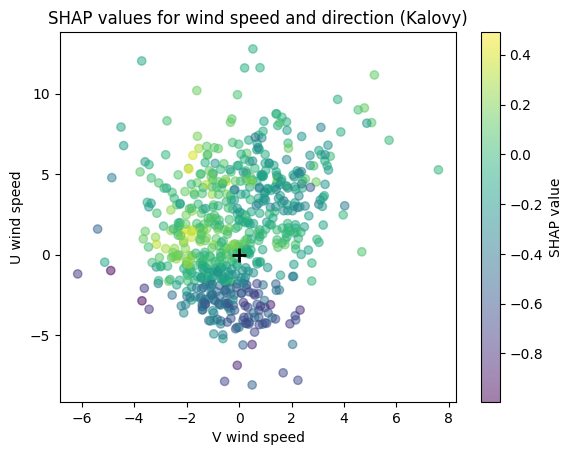

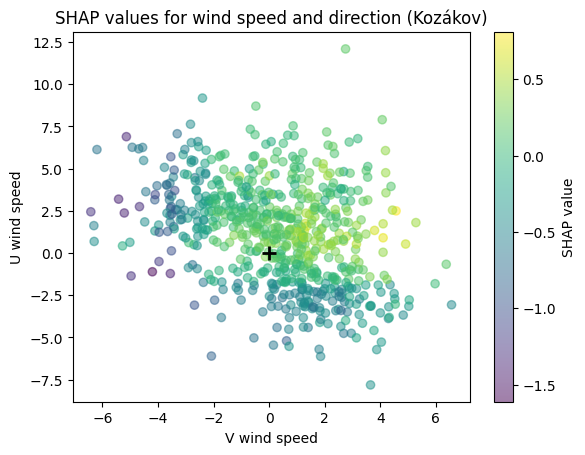

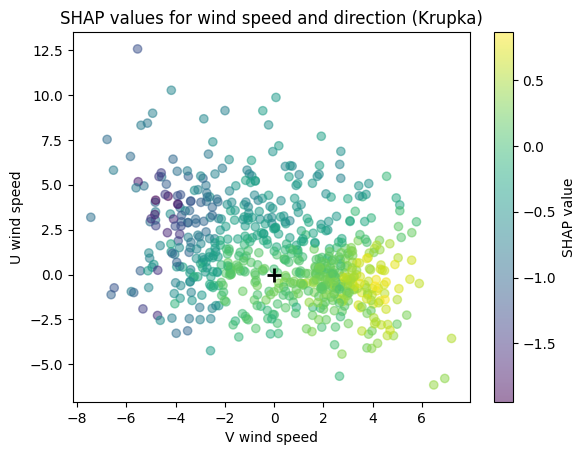

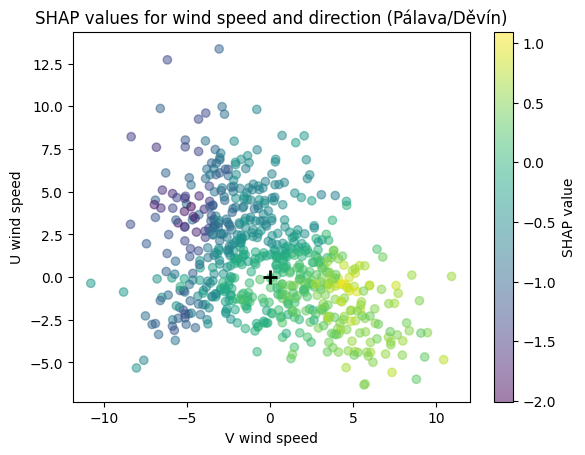

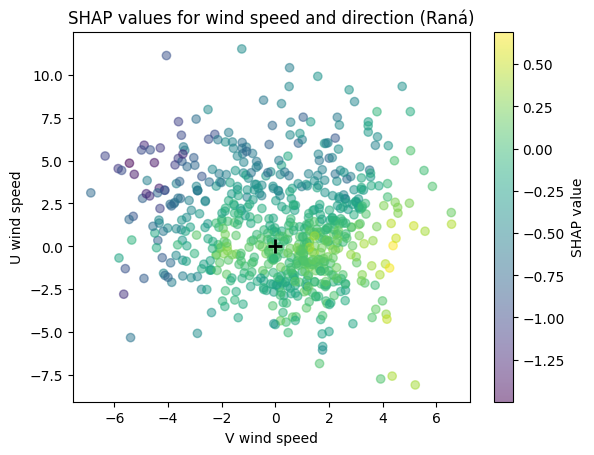

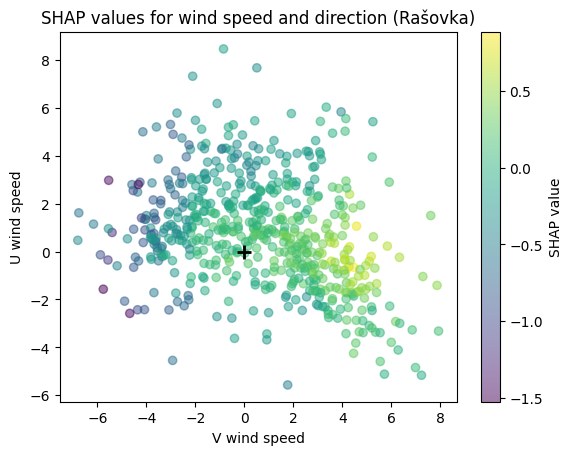

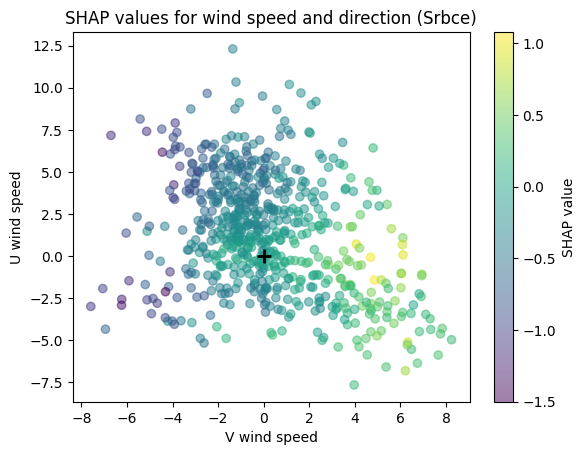

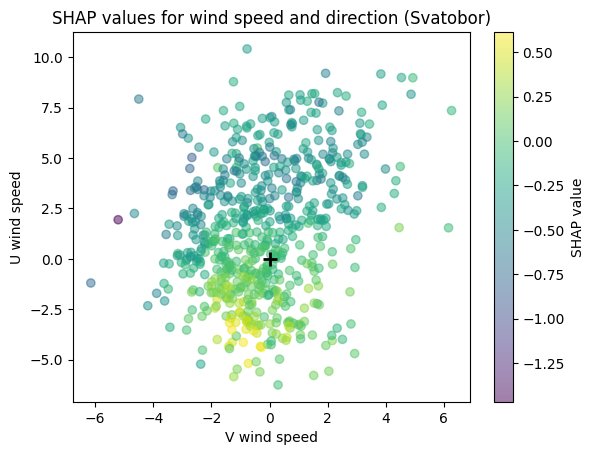

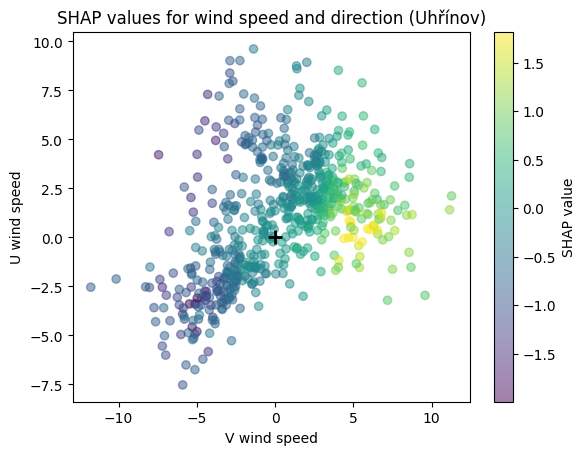

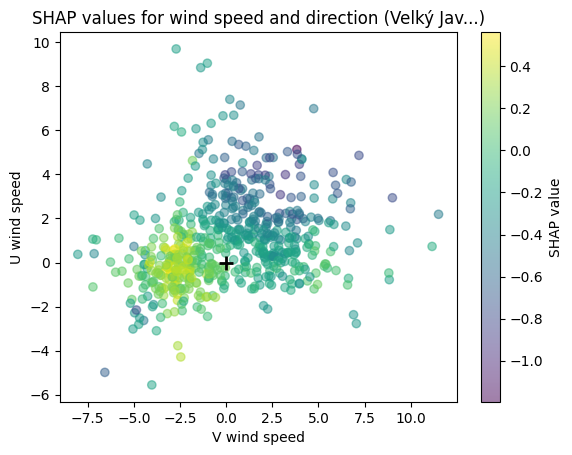

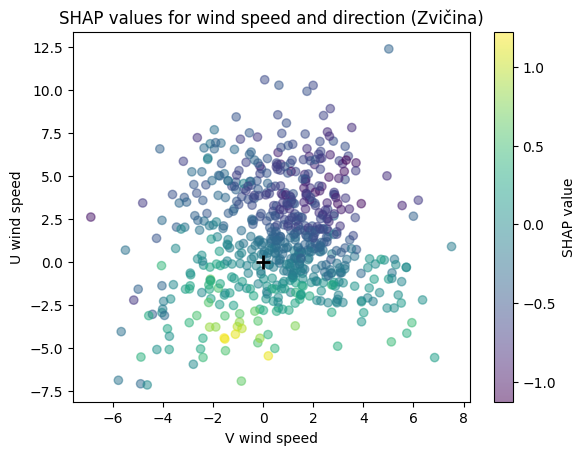

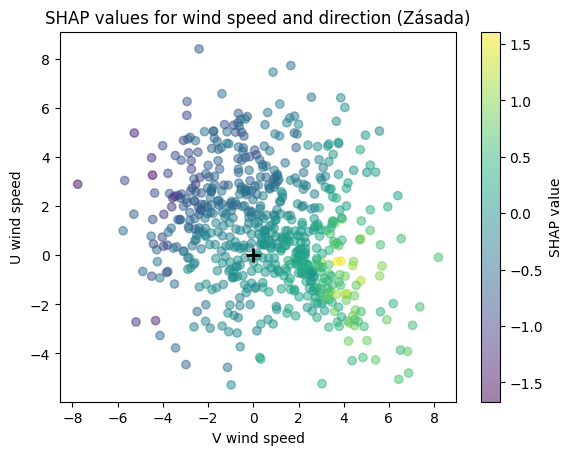

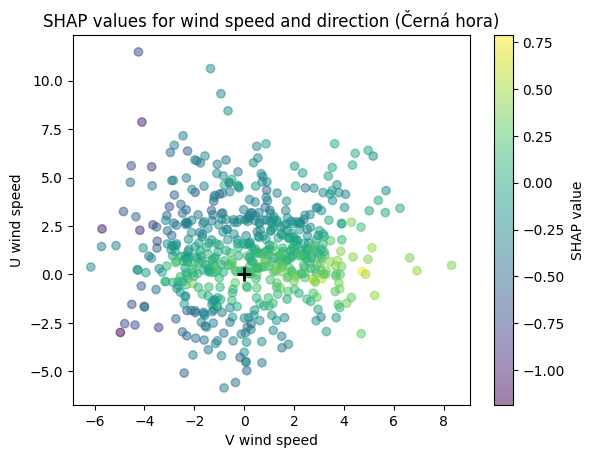

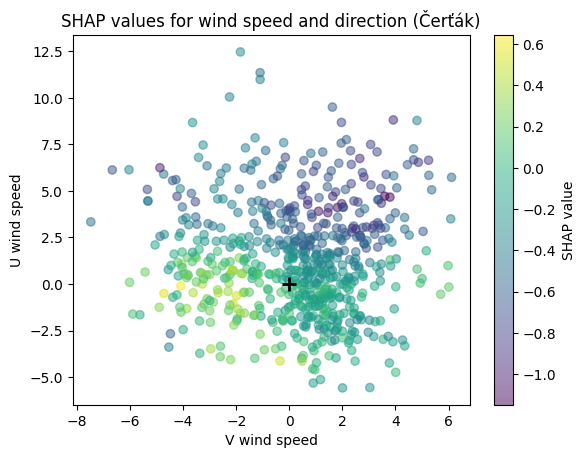

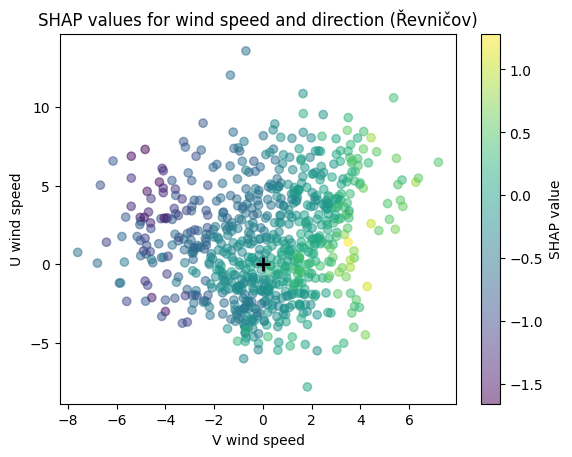

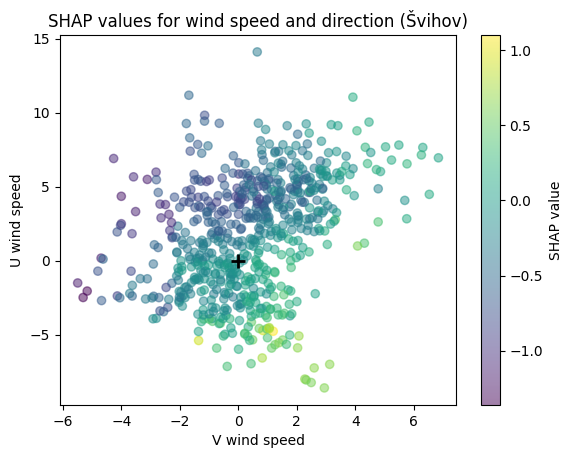

In [19]:
for launch in launches:
    mask = X_val['launch'] == launch
    utils.scatter_wind_shap_values(shap_values, mask=mask, label=launch);